In [ ]:
#!pip uninstall pyTsetlinMachineParallel

In [19]:
!pip install pyTsetlinMachineParallel
!export OMP_NUM_THREADS=10
from pyTsetlinMachineParallel.tm import MultiClassTsetlinMachine

In [20]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

In [4]:
from pyTsetlinMachine.tools import Binarizer
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

from pylab import *
import bisect
import pandas as pd

import os
import pickle
import copy
import matplotlib.colors as colors
import fnmatch  

2025-02-27 12:40:22.147035: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
class Booleanizer:
  def __init__(self, mdn = False, encoding = 'one_hot', max_bits_per_feature = 1, equal_bins = True):
    #encoding = {'one_hot', 'binary', 'termometer'}
    self.mdn = mdn
    self.encoding = encoding
    self.max_bits_per_feature = max_bits_per_feature
    self.equal_bins = equal_bins
    return

  def fit(self, X):
    self.number_of_features = 0
    self.bins_list = []
    self.bits_per_feature = []
    bins_no = 0
    for i in range(X.shape[1]):
      uv = np.unique(X[:,i])
      if self.encoding == 'one_hot' or self.encoding == 'termometer':
        if uv.size < self.max_bits_per_feature and self.equal_bins == False:
          bins_no = uv.size
        else:
          bins_no = self.max_bits_per_feature
        self.number_of_features += bins_no
        self.bits_per_feature.append(bins_no)
      else:
        if uv.size < 2 ** self.max_bits_per_feature and self.equal_bins == False:
          bins_no = uv.size
          bits_no = ceil(np.log2(bins_no)).astype(int)
          self.number_of_features += bits_no
          self.bits_per_feature.append(bits_no)
        else:
          bins_no = 2 ** self.max_bits_per_feature
          self.number_of_features += self.max_bits_per_feature
          self.bits_per_feature.append(self.max_bits_per_feature)

      if self.mdn == True:
        # if bins_no == 2:
        #   bins = np.array(np.median(X[:,i]))
        # else:
          q, bins = pd.qcut(X[:,i], q=bins_no, retbins=True, duplicates='raise') #duplicates='drop'
          #bins = bins[1:-1]
      else:
        bins = np.linspace(X[:,i].min(), X[:,i].max(), bins_no + 1) #[1:-1]
        #print(bins)

      self.bins_list.append(bins)
    #self.bins_list = np.array(self.bins_list)
    return

  def transform(self, X):
    X_indx = np.zeros((X.shape[0], X.shape[1]), int64)
    for i in range(X.shape[1]):
      for j in range(X.shape[0]):
        X_indx[j,i] = bisect.bisect_right(self.bins_list[i][1:-1], X[j,i]) #bisect_left

    if (self.encoding == 'binary'):
#      X_out = np.array((((X_indx[:, 0, None] & (1 << np.arange(self.bits_per_feature[i]))[::-1])) > 0).astype(int))
      X_out = np.array((((X_indx[:, 0, None] & (1 << np.arange(self.bits_per_feature[i]))[::-1])) > 0).astype(int))
      for i in range(1, X.shape[1]):
#        X_out = np.concatenate((X_out, np.array((((X_indx[:, i, None] & (1 << np.arange(self.bits_per_feature[i]))[::-1])) > 0).astype(int))), axis=1)
        X_out = np.concatenate((X_out, np.array((((X_indx[:, i, None] & (1 << np.arange(self.bits_per_feature[i])))) > 0).astype(int))), axis=1)
        #print(i, X_out.shape)
    elif (self.encoding == 'one_hot'):
#      X_out = np.fliplr(np.array(to_categorical(X_indx[:, 0], num_classes=self.bits_per_feature[i])).astype(int))
      X_out = np.array(to_categorical(X_indx[:, 0], num_classes=self.bits_per_feature[i]).astype(int))
      #print(i, X_out.shape)
      for i in range(1, X.shape[1]):
#        X_out = np.concatenate((X_out, np.fliplr(np.array(to_categorical(X_indx[:, i], num_classes=self.bits_per_feature[i])).astype(int))), axis=1)
        X_out = np.concatenate((X_out, np.array(to_categorical(X_indx[:, i], num_classes=self.bits_per_feature[i])).astype(int)), axis=1)
        #print(i, X_out.shape)
    else:
      X_out = np.zeros((X.shape[0], self.number_of_features))
      pos = 0
      #print(X.shape[1], self.bits_per_feature[i])
      for i in range(X.shape[1]):
        for j in range(self.bits_per_feature[i]):
          X_out[:,pos] = (X[:,i] >= self.bins_list[i][j]) #self.unique_values[i][j])
          #print(X[:,i], self.bins_list[:,0:-1][i,j])
          pos += 1

    # pos = 0
    # for i in range(X.shape[1]):
    #   for j in range(self.bins_list[i].size):
    #     X_transformed[:,pos] = (X[:,i] >= self.bins_list[i][j])
    #     pos += 1

    return X_out

In [6]:
def tm_clause_display_trunc(tm, x_shape, y_shape, features_indx, polarity = 0, y = 0, 
                            clause_lable = [], bn_range = []):
  from matplotlib import rcParams
  rcParams['font.family'] = 'DejaVu Sans Mono' #'Liberation Mono' #'DejaVu Sans Mono'
  rcParams.update({'font.size': 10})
  literals_indx = get_literals_indx(features_indx, tm)
  l = np.zeros((tm.number_of_clauses//2, len(literals_indx)//2), dtype=np.uint32)
      
  for i in range(polarity, tm.number_of_clauses, 2):
    kp = 0
    kn = 0
    for j in literals_indx: #(tm.number_of_features):
      if tm.ta_action(y, i, j) == 1: # symbol's class
        if j < tm.number_of_features//2:
          l[i//2, kp] = 1
        else:
          l[i//2, kn] = 2
      if j < tm.number_of_features//2:
        kp += 1
      else: 
        kn +=1

  palette = np.array([[  255,   255,   255],   # white
                      [  85, 109,  239], 
                      [  218, 65, 93]])

  fig = plt.figure(figsize=(11,10)) #(14,10)
  bm_ordered = [bm[index] for index in features_indx]

  for i in range(0,tm.number_of_clauses//2):
    ax = plt.subplot(tm.number_of_clauses//20,10,i+1)
    if i==0:
      plt.yticks(np.arange(len(bm_ordered)), bm_ordered)
    elif i==tm.number_of_clauses//2-1 and bn_range != []:
      ax.yaxis.tick_right()
      plt.yticks(np.arange(len(features_indx)), [bn_range[index] for index in features_indx])
    else:
      plt.yticks([])
    plt.yticks(np.arange(0.5, y_shape-0.5, 1), minor = True)
    plt.xticks(np.arange(0, x_shape+1, 1))
    plt.xticks(np.arange(0.5, x_shape+0.5, 1), minor = True)
    plt.tick_params(which='minor', bottom=False, left=False, right=False)
    plt.grid(which='minor')
    if clause_lable != []:
      plt.xlabel(clause_lable[i])

    RGB = palette[l[i].reshape(y_shape, x_shape)]
    plt.imshow(RGB)

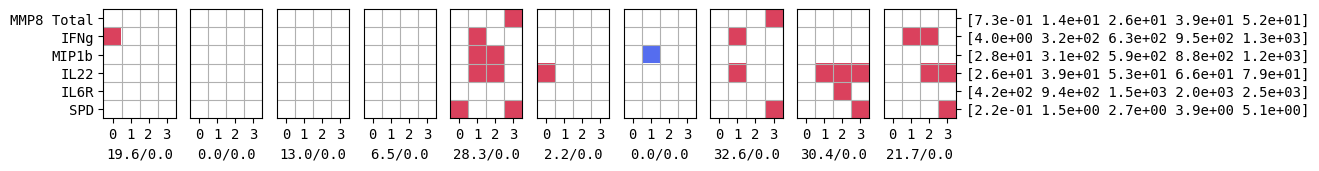

In [399]:
tm_clause_display_trunc(tm_max, x_shape = 4, y_shape = k, features_indx = features_indx_2[:-(bms_no-k)], 
                        polarity = polarity, y = yclass, clause_lable = clause_label, 
                        bn_range = bn_range)

In [1062]:
k = 3
print(features_indx_2[:-(bms_no-k)])
print(get_literals_indx(features_indx_2[:-(bms_no-k)], tm_max))
print(get_literals_indx([0, 39], tm_max))

[23 31 39]
[ 92  93  94  95 252 253 254 255 124 125 126 127 284 285 286 287 156 157
 158 159 316 317 318 319]
[  0   1   2   3 160 161 162 163 156 157 158 159 316 317 318 319]


In [7]:
def tm_clause_display(tm, x_shape, y_shape, polarity = 0, y = 0, 
                      clause_lable = [], bn_range = []):
  from matplotlib import rcParams
  rcParams['font.family'] = 'DejaVu Sans Mono' #'Liberation Mono' #'DejaVu Sans Mono'
  rcParams.update({'font.size': 10})
  c = 0
  l = np.zeros((tm.number_of_clauses//2, tm.number_of_features//2), dtype=np.uint32)
  l_0 = np.zeros((tm.number_of_features//2), dtype=np.uint32)
  l_1 = np.zeros((tm.number_of_features//2), dtype=np.uint32)
  for i in range(polarity, tm.number_of_clauses, 2):
    for j in range(tm.number_of_features):
      if tm.ta_action(y, i, j) == 1: # symbol's class
        if j < tm.number_of_features//2:
          l[i//2, j] = 1
          l_1[j] += 1
          c+=1
#          print(i, '-', j, end = ' ')
        else:
          l[i//2, j-tm.number_of_features//2] = 2
          l_0[j-tm.number_of_features//2] += 1

#  print(' c=', c)
#  print(l_0.reshape(y_shape, x_shape).transpose())
#  print(l_1.reshape(y_shape, x_shape).transpose())
    
  # palette = np.array([[  255,   255,   255],   # white
  #                   [  0, 204,   0],   # dark green
  #                   [  204, 0,  0]])   # dark red
  # palette = np.array([[  255,   255,   255],   # white
  #                   [  10, 120,   50],   # dark green
  #                   [  190, 15,  10]])   # dark red
  palette = np.array([[  255,   255,   255],   # white
                      [  85, 109,  239], 
                      [  218, 65, 93]])
  # palette = np.array([[  255,   255,   255],   # white
  #                     [  85, 109,  239], 
  #                     [  201, 35, 44]])
  fig = plt.figure(figsize=(11,10)) #(14,10)
#  bm = ('IFNg', 'IL1b', 'IL2', 'IL4', 'IL6', 'IL10', 'IL12p70', 'IL13', 'TNFa', 'GMCSF', 'IL1a', 'IL5', 'IL7', 'IL12/IL23p40', 'IL15', 'IL16', 'IL17A', 'TNFb', 'VEGF', 'Eotaxin', 'MIP1b', 'Eotaxin3', 'TARC', 'IP10', 'MIP1a', 'MCP1', 'MDC', 'MCP4', 'IL6R', 'IL18', 'IL22', 'TGFb', 'IL8', 'MMPsubstr', 'HNEsubstr', 'Zym', 'MMP8 Total', 'HNE', 'Calprotectin', 'SPD', 'TotalCellCount', 'CD3+live(%)', 'CD14+live(%)', 'CD15+live(%)', 'CD4/CD8', 'CD4/CD3(%)', 'CD8/CD3(%)', 'g9T/CD3(%)', 'd2T/CD3(%)')
#  bm = ('IFNg', 'IL1b', 'IL2', 'IL4', 'IL6', 'IL10', 'IL12p70', 'IL13', 'TNFa', 'GMCSF', 'IL1a', 'IL5', 'IL7', 'IL12/IL23p40', 'IL15', 'IL16', 'IL17A', 'TNFb', 'VEGF', 'Eotaxin', 'MIP1b', 'Eotaxin3', 'TARC', 'IP10', 'MIP1a', 'MCP1', 'MDC', 'MCP4', 'IL6R', 'IL18', 'IL22', 'TGFb', 'IL8', 'MMPsubstr', 'HNEsubstr', 'MMP8 Total', 'HNE', 'Calprotectin', 'SPD', 'TotalCellCount')

  for i in range(0,tm.number_of_clauses//2):
    ax = plt.subplot(tm.number_of_clauses//20,10,i+1)
#    plt.xticks([0, 1, 2, 3])
    if i==0:
      plt.yticks(np.arange(len(bm)), bm)
    #plt.yticks(np.arange(0, y_shape, 1))
    elif i==tm.number_of_clauses//2-1 and bn_range != []:
      ax.yaxis.tick_right()
      plt.yticks(np.arange(len(bn_range)), bn_range)
    else:
      plt.yticks([])
    plt.yticks(np.arange(0.5, y_shape-0.5, 1), minor = True)
    plt.xticks(np.arange(0, x_shape+1, 1))
    plt.xticks(np.arange(0.5, x_shape+0.5, 1), minor = True)
    plt.tick_params(which='minor', bottom=False, left=False, right=False)
    plt.grid(which='minor')
#    plt.grid(True)
    if clause_lable != []:
      plt.xlabel(clause_lable[i])

    #RGB = palette[l[i].reshape(int(np.sqrt(tm.number_of_features//2)),int(np.sqrt(tm.number_of_features//2)))]
#    print(l[i].reshape(y_shape, x_shape).transpose())
    RGB = palette[l[i].reshape(y_shape, x_shape)]
    plt.imshow(RGB)

  # filename = "class-%d_polarity-%d_%d.png" % (y, polarity, k)
  # fig.savefig(filename)
  # plt.close()

    
  fig = plt.figure(figsize=(16.5, 3))
  ax = plt.subplot(2,1,1)
  ax.xaxis.tick_top()
  #ax.set_ylim(0, 3)
  plt.xticks(np.arange(len(bm)), bm, rotation=90)
  plt.yticks(np.arange(0.5, x_shape-0.5, 1), minor = True)
  plt.yticks(np.arange(0, x_shape+1, 1), np.arange(x_shape-1, -2, -1)) #(0, x_shape+1, 1)
  plt.xticks(np.arange(0.5, y_shape-0.5, 1), minor = True)
  plt.tick_params(which='minor', bottom=True, left=False, right=False)
  plt.grid(which='minor')
  plt.imshow(np.flipud(l_1.reshape(y_shape, x_shape).transpose()), cmap=matplotlib.colormaps.get_cmap('BuGn')) #viridis  magma
  plt.subplot(2,1,2)
  plt.xticks(np.arange(len(bn_range)), bn_range, rotation=90)
  plt.yticks(np.arange(0.5, x_shape-0.5, 1), minor = True)
  plt.yticks(np.arange(0, x_shape+1, 1), np.arange(x_shape-1, -2, -1))
  plt.xticks(np.arange(0.5, y_shape-0.5, 1), minor = True)
  plt.tick_params(which='minor', bottom=False, left=False, right=False)
  plt.grid(which='minor')
  plt.imshow(np.flipud(l_0.reshape(y_shape, x_shape).transpose()), cmap=matplotlib.colormaps.get_cmap('OrRd'))


  # # filename = "avg-not-X_class-%d_polarity-%d_%d.png" % (y, polarity, k)
  # # fig.savefig(filename)
  # # plt.close()

  # fig = plt.figure(figsize=(6, 6))
  # plt.imshow(l_1.reshape(14, 14), cmap=matplotlib.colormaps.get_cmap('BuGn'))
  # # filename = "avg-X_class-%d_polarity-%d_%d.png" % (y, polarity, k)
  # # fig.savefig(filename)
  # # plt.close()

In [8]:
def clause_score_average(X, Y, tm):
  clause_score = np.zeros((tm.number_of_classes, 2, tm.number_of_clauses), dtype=float)
  #the second dimension is: 0 - True Positives (TP), 1 - True Negatives (TN)
  count_class = np.zeros((tm.number_of_classes), dtype=np.uint32)
  clause_output = tm.transform(X, inverted=False)
  for i in range(X.shape[0]): #tqdm
    count_class[Y[i]] += 1
    for j in range(tm.number_of_classes):
      if j == Y[i]:
        clause_score[j, 0] += clause_output[i][j*tm.number_of_clauses:j*tm.number_of_clauses+tm.number_of_clauses]
      else:
        clause_score[j, 1] += clause_output[i][j*tm.number_of_clauses:j*tm.number_of_clauses+tm.number_of_clauses]
  for i in range(tm.number_of_classes):
    clause_score[i, 0] /= count_class[i]
    clause_score[i, 1] /= X.shape[0] - count_class[i]
  return clause_score

In [9]:
def clause_score_average_trunk(X, Y, tm, tm_clauses):
  clause_score = np.zeros((tm.number_of_classes, 2, tm.number_of_clauses), dtype=float)
  #the second dimension is: 0 - True Positives (TP), 1 - True Negatives (TN)
  count_class = np.zeros((tm.number_of_classes), dtype=np.uint32)
#  clause_output = tm.transform(X, inverted=False)
  clause_output = tm_transform(tm, tm_clauses, X)
  for i in range(X.shape[0]): #tqdm
    count_class[Y[i]] += 1
    for j in range(tm.number_of_classes):
      if j == Y[i]:
        clause_score[j, 0] += clause_output[i][j*tm.number_of_clauses:j*tm.number_of_clauses+tm.number_of_clauses]
      else:
        clause_score[j, 1] += clause_output[i][j*tm.number_of_clauses:j*tm.number_of_clauses+tm.number_of_clauses]
  for i in range(tm.number_of_classes):
    clause_score[i, 0] /= count_class[i]
    clause_score[i, 1] /= X.shape[0] - count_class[i]
  return clause_score

In [10]:
def clause_mask(tm, polarity = 0, yclass=0, clause_score_av = []):
  
  mask_neg = np.zeros((tm.number_of_features//2), dtype=np.float32)
  mask_pos = np.zeros((tm.number_of_features//2), dtype=np.float32)
  if len(clause_score_av) == 0: #clause_score_av == []
    clause_weight = np.ones((tm.number_of_clauses//2), dtype=np.float32)
  else:
    clause_weight = np.zeros((tm.number_of_clauses//2), dtype=np.float32)
    for i in range(tm.number_of_clauses//2):
      if polarity == 0:
        clause_weight[i] = clause_score_av[yclass, 0][polarity::2][i] - clause_score_av[yclass, 1][polarity::2][i]
      else:
        clause_weight[i] = clause_score_av[yclass, 1][polarity::2][i] - clause_score_av[yclass, 0][polarity::2][i]

#  print(clause_weight)

  for i in range(polarity, tm.number_of_clauses, 2):
    for j in range(tm.number_of_features):
      if tm.ta_action(yclass, i, j) == 1: # symbol's class
        if j < tm.number_of_features//2:
          mask_pos[j] += clause_weight[i//2]
        else:
          mask_neg[j-tm.number_of_features//2] += clause_weight[i//2]

  return mask_neg, mask_pos   

In [11]:
def get_tm_clauses(tm, features_indx):
    tm_clauses = np.zeros((tm.number_of_classes * tm.number_of_clauses, tm.number_of_features), dtype=np.uint32)
    features_indx =  np.concatenate((features_indx, features_indx + (tm.number_of_features // 2)), axis=0)
    for i in range(tm.number_of_classes):
        for j in range(0, tm.number_of_clauses):
            for k in features_indx: #range(tm.number_of_features)
                tm_clauses[i*tm.number_of_clauses+j, k] = tm.ta_action(i, j, k)
    return tm_clauses

def get_tm_clauses_2(tm, features_indx):
    tm_clauses = np.zeros((tm.number_of_classes * tm.number_of_clauses, tm.number_of_features), dtype=np.uint32)
    for i in range(tm.number_of_classes):
        for j in range(0, tm.number_of_clauses):
            for k in features_indx: #range(tm.number_of_features)
                tm_clauses[i*tm.number_of_clauses+j, k] = tm.ta_action(i, j, k)
    return tm_clauses

def tm_transform(tm, tm_clauses, X):
    clause_out = np.zeros((X.shape[0], tm.number_of_classes * tm.number_of_clauses), dtype=np.int32)
    for k in range(X.shape[0]): #tqdm
        x_vector = np.ones((X.shape[1]), dtype=np.uint32)
        x_vector = np.concatenate((X[k], (X[k] ^ x_vector)), axis=0)
        for i in range(tm.number_of_classes):
            for j in range(tm.number_of_clauses):
                # first check if clause is all exclude, then return 0 as clause output
#                if (i==1 and j==19):
#                    print(tm_clauses[i*tm.number_of_clauses+j])
#                    print(x_vector)
#                    print((tm_clauses[i*tm.number_of_clauses+j] & x_vector) ^ tm_clauses[i*tm.number_of_clauses+j])
                if np.logical_or.reduce(tm_clauses[i*tm.number_of_clauses+j]) != False and np.logical_or.reduce((tm_clauses[i*tm.number_of_clauses+j] & x_vector) ^ tm_clauses[i*tm.number_of_clauses+j]) == False:
                    clause_out[k, i*tm.number_of_clauses+j] = 1 #check!!!    
    return clause_out                

def tm_predict(tm, tm_clauses, X):
    Y_predict = np.zeros((X.shape[0]), dtype=np.uint32)
    clause_out = tm_transform(tm, tm_clauses, X)
    class_out = np.zeros((tm.number_of_classes), dtype=np.int32)
    for k in range(X.shape[0]):
        for i in range(tm.number_of_classes):
            class_out[i] = (clause_out[k, i*tm.number_of_clauses:i*tm.number_of_clauses + tm.number_of_clauses:2].sum() - clause_out[k, i*tm.number_of_clauses + 1:i*tm.number_of_clauses + tm.number_of_clauses:2].sum())
#                print(class_out[i])
        Y_predict[k] = np.argmax(class_out)
    return Y_predict

[156  83 123 132 143]
TM accuracy:   64.63414634146342
TM accuracy:   76.98412698412699
TM accuracy:   47.05882352941176


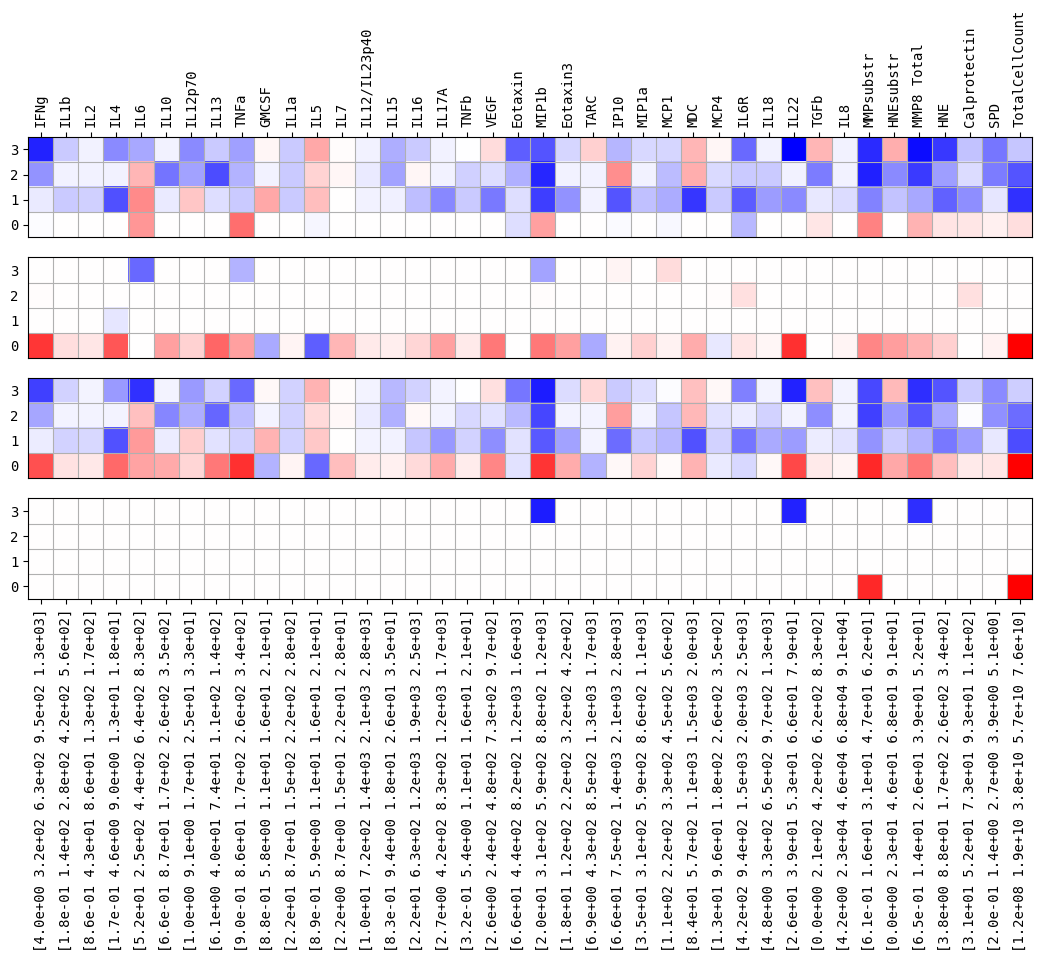

In [132]:
#print(get_tm_clauses(tm_max)[1*20+19])
#x_vector = np.ones((X_bn.shape[1]), dtype=np.uint32)
#x_vector = np.concatenate((X_bn[0], (X_bn[0] ^ x_vector)), axis=0)
#print(x_vector)
#print(tm_max.transform(X_bn[2:3], inverted=False))
#print(tm_transform(tm_max, get_tm_clauses(tm_max), X_bn[2:3]))
#print(tm_predict(tm_max, get_tm_clauses(tm_max), X_bn))
#features_indx = np.arange(0, (tm_max.number_of_features-1)//2)
literals_indx, weight, features_indx_1, features_indx_2 = top_dif_literals(tm_max, cl_0=1, cl_1=0, n=5, x_size=bms_no, y_size=4, clause_score_av=clause_score_av, clause ='all', normalized=True)
print(literals_indx)
print('TM accuracy:  ', 100*(tm_predict(tm_max, get_tm_clauses(tm_max, literals_indx), X_bn) == Y).mean())
print('TM accuracy:  ', 100*(tm_predict(tm_max, get_tm_clauses(tm_max, literals_indx), X_train) == Y_train).mean())
print('TM accuracy:  ', 100*(tm_predict(tm_max, get_tm_clauses(tm_max, literals_indx), X_test) == Y_test).mean())

In [ ]:
[[0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0
  0 0 0 1]]

In [12]:
def print_clauses(tm):
    for i in range(tm.number_of_classes):
        print("\nClass #%d Positive Clauses:\n" % (i))
        for j in range(0, tm.number_of_clauses, 2):
            print("Clause #%d: " % (j), end=' ')
            l = []
            for k in range(tm.number_of_features):
                if tm.ta_action(i, j, k) == 1:
                    if k < tm.number_of_features//2:
                        l.append(" x%d" % (k))
                    else:
                        l.append("¬x%d" % (k-tm.number_of_features//2))
            print(" ∧ ".join(l))

        print("\nClass #%d Negative Clauses:\n" % (i))
        for j in range(1, tm.number_of_clauses, 2):
            print("Clause #%d: " % (j), end=' ')
            l = []
            for k in range(tm.number_of_features):
                if tm.ta_action(i, j, k) == 1:
                    if k < tm.number_of_features//2:
                        l.append(" x%d" % (k))
                    else:
                        l.append("¬x%d" % (k-tm.number_of_features//2))
            print(" ∧ ".join(l))

In [13]:
def top_dif_literals(tm, cl_0, cl_1, n, x_size, y_size, clause_score_av=[], clause='all', normalized=False):
    no_of_bags = tm.number_of_features // 2 // x_size
    if clause == 'positive':        
        mask_0_neg, mask_0_pos = clause_mask(tm, 0, cl_0, clause_score_av)
        mask_1_neg, mask_1_pos = clause_mask(tm, 0, cl_1, clause_score_av)
        if normalized == True:
            mask_0_neg = mask_0_neg / mask_0_neg.max()
            mask_0_pos = mask_0_pos / mask_0_pos.max()
            mask_1_neg = mask_1_neg / mask_1_neg.max()
            mask_1_pos = mask_1_pos / mask_1_pos.max()            
        mask_pos_neg = mask_0_neg - mask_1_neg
        mask_pos_pos = mask_1_pos - mask_0_pos
    elif clause == 'negative':
        mask_0_neg, mask_0_pos = clause_mask(tm, 1, cl_0, clause_score_av)
        mask_1_neg, mask_1_pos = clause_mask(tm, 1, cl_1, clause_score_av)
        if normalized == True:
            mask_0_neg = mask_0_neg / mask_0_neg.max()
            mask_0_pos = mask_0_pos / mask_0_pos.max()
            mask_1_neg = mask_1_neg / mask_1_neg.max()
            mask_1_pos = mask_1_pos / mask_1_pos.max()            
        mask_pos_neg = mask_1_neg - mask_0_neg
        mask_pos_pos = mask_0_pos - mask_1_pos
    else:
        mask_0_neg, mask_0_pos = clause_mask(tm, 0, cl_0, clause_score_av)
        mask_1_neg, mask_1_pos = clause_mask(tm, 0, cl_1, clause_score_av)
        if normalized == True:
            mask_0_neg = mask_0_neg / mask_0_neg.max()
            mask_0_pos = mask_0_pos / mask_0_pos.max()
            mask_1_neg = mask_1_neg / mask_1_neg.max()
            mask_1_pos = mask_1_pos / mask_1_pos.max()            
        mask_pos_neg = mask_0_neg - mask_1_neg
        mask_pos_pos = mask_1_pos - mask_0_pos
        mask_0_neg, mask_0_pos = clause_mask(tm, 1, cl_0, clause_score_av)
        mask_1_neg, mask_1_pos = clause_mask(tm, 1, cl_1, clause_score_av)
        if normalized == True:
            mask_0_neg = mask_0_neg / mask_0_neg.max()
            mask_0_pos = mask_0_pos / mask_0_pos.max()
            mask_1_neg = mask_1_neg / mask_1_neg.max()
            mask_1_pos = mask_1_pos / mask_1_pos.max()            
        mask_pos_neg = mask_pos_neg - (mask_0_neg - mask_1_neg)
        mask_pos_pos = mask_pos_pos - (mask_1_pos - mask_0_pos)
        # mask_pos_neg = mask_pos_neg + (mask_1_pos - mask_0_pos)
        # mask_pos_pos = mask_pos_pos + (mask_0_neg - mask_1_neg) 
        
    # mask_pos_neg = mask_0_neg - mask_1_neg
    # mask_pos_pos = mask_1_pos - mask_0_pos

    #    print(mask_0_neg.reshape(14,14))
#    print(mask_1_neg.reshape(14,14))
#    print((mask_0_neg - mask_1_neg).reshape(14,14))
#    print(mask_0_pos.reshape(14,14))
#    print(mask_1_pos.reshape(14,14))
#    print((mask_0_pos - mask_1_pos).reshape(14,14))
#    print(mask_pos_neg.reshape(x_size, x_size))
#    print(mask_pos_pos.reshape(x_size, x_size))
#    print((mask_pos_neg + mask_pos_pos).reshape(x_size, x_size))

    #mask_abs = (np.abs(mask_pos_neg) + np.abs(mask_pos_pos)) #absolute values
    mask_abs = np.abs(mask_pos_neg + mask_pos_pos)
#    print(mask_abs.reshape(49,4))
    topn_indx = mask_abs.argsort()[-n:][::-1] #get the first n indexes of an array sorted in a reverse order
    literal_indx = mask_abs.argsort()[::-1]
    
#    print(literal_indx)    
    feature_indx_1 = np.zeros((x_size), dtype=np.uint32)
    z = 1
    for i in range(len(literal_indx)):
        if feature_indx_1[literal_indx[i] // no_of_bags] == 0:
            feature_indx_1[literal_indx[i] // no_of_bags] = z
            z += 1
    feature_indx_2 = mask_abs.reshape(x_size, no_of_bags).sum(axis=1).argsort()[::-1]
#    print(feature_indx_1)
#    print(feature_indx_2)
#    print(mask_abs.reshape(49, no_of_bags).sum(axis=1))
#    print(mask_abs.reshape(49, no_of_bags))
#    print(mask_abs)
    
#    print(mask_abs[48*4:48*4+4])
#            print(i, literal_indx[i], literal_indx[i] // no_of_bags)
#    print(feature_indx[14])
#    print(feature_indx.argsort())
    

#    print(topn_indx, mask_abs[topn_indx])
    
    mask = mask_pos_neg + mask_pos_pos
#    print(mask.reshape(49,4))
#    print(mask.argsort()[-n:][::-1], mask[mask.argsort()[-n:][::-1]])
    a = np.zeros(mask.shape)
    #get values of the literals which abs() is more or equal to the last of top_n
    a[mask_abs >= mask_abs[topn_indx[n-1]]] = mask[mask_abs >= mask_abs[topn_indx[n-1]]]
    
#    print(mask_pos_neg.argsort()[::-1])

    # bm = ('IFNg', 'IL1b', 'IL2', 'IL4', 'IL6', 'IL10', 'IL12p70', 'IL13', 'TNFa', 'GMCSF', 'IL1a', 'IL5', 'IL7', 'IL12/IL23p40', 'IL15', 'IL16', 'IL17A', 'TNFb', 'VEGF', 'Eotaxin', 'MIP1b', 'Eotaxin3', 'TARC', 'IP10', 'MIP1a', 'MCP1', 'MDC', 'MCP4', 'IL6R', 'IL18', 'IL22', 'TGFb', 'IL8', 'MMPsubstr', 'HNEsubstr', 'Zym', 'MMP8 Total', 'HNE', 'Calprotectin', 'SPD', 'TotalCellCount', 'CD3+live(%)', 'CD14+live(%)', 'CD15+live(%)', 'CD4/CD8', 'CD4/CD3(%)', 'CD8/CD3(%)', 'g9T/CD3(%)', 'd2T/CD3(%)')
    # bm = ('IFNg', 'IL1b', 'IL2', 'IL4', 'IL6', 'IL10', 'IL12p70', 'IL13', 'TNFa', 'GMCSF', 'IL1a', 'IL5', 'IL7', 'IL12/IL23p40', 'IL15', 'IL16', 'IL17A', 'TNFb', 'VEGF', 'Eotaxin', 'MIP1b', 'Eotaxin3', 'TARC', 'IP10', 'MIP1a', 'MCP1', 'MDC', 'MCP4', 'IL6R', 'IL18', 'IL22', 'TGFb', 'IL8', 'MMPsubstr', 'HNEsubstr', 'MMP8 Total', 'HNE', 'Calprotectin', 'SPD', 'TotalCellCount')
    fig = plt.figure(figsize=(16.5, 6))
    ax = plt.subplot(4,1,1)
    ax.xaxis.tick_top()
    plt.xticks(np.arange(len(bm)), bm, rotation=90)
    plt.yticks(np.arange(0.5, y_size-0.5, 1), minor = True)
    plt.yticks(np.arange(0, y_size+1, 1), np.arange(y_size-1, -2, -1)) #(0, x_shape+1, 1)
    plt.xticks(np.arange(0.5, x_size-0.5, 1), minor = True)
    plt.tick_params(which='minor', top=False, bottom=False, left=False, right=False)
    plt.grid(which='minor')
    plt.imshow(np.flipud(mask_pos_neg.reshape(x_size, y_size).transpose()), norm=colors.CenteredNorm(), cmap=matplotlib.colormaps.get_cmap('bwr')) #viridis  magma

    plt.subplot(4,1,2)
    plt.yticks(np.arange(0.5, y_size-0.5, 1), minor = True)
    plt.yticks(np.arange(0, y_size+1, 1), np.arange(y_size-1, -2, -1))
    plt.xticks(np.arange(0.5, x_size-0.5, 1), minor = True)
    plt.tick_params(which='minor', bottom=False, left=False, right=False)
    plt.tick_params(bottom=False, left=False, right=False, labelbottom=False)
    plt.grid(which='minor')    
    plt.imshow(np.flipud(mask_pos_pos.reshape(x_size, y_size).transpose()), norm=colors.CenteredNorm(), cmap=matplotlib.colormaps.get_cmap('bwr')) 
    
    plt.subplot(4,1,3)
    plt.yticks(np.arange(0.5, y_size-0.5, 1), minor = True)
    plt.yticks(np.arange(0, y_size+1, 1), np.arange(y_size-1, -2, -1))
    plt.xticks(np.arange(0.5, x_size-0.5, 1), minor = True)
    plt.tick_params(which='minor', bottom=False, left=False, right=False)
    plt.tick_params(bottom=False, left=False, right=False, labelbottom=False)
    plt.grid(which='minor')     
    plt.imshow(np.flipud((mask_pos_neg + mask_pos_pos).reshape(x_size, y_size).transpose()), norm=colors.CenteredNorm(), cmap=matplotlib.colormaps.get_cmap('bwr')) 

    plt.subplot(4,1,4)
    plt.xticks(np.arange(len(bn_range)), bn_range, rotation=90)
    plt.yticks(np.arange(0.5, y_size-0.5, 1), minor = True)
    plt.yticks(np.arange(0, y_size+1, 1), np.arange(y_size-1, -2, -1))
    plt.xticks(np.arange(0.5, x_size-0.5, 1), minor = True)
    plt.tick_params(which='minor', bottom=False, left=False, right=False)
    plt.grid(which='minor')
    plt.imshow(np.flipud(a.reshape(x_size, y_size).transpose()), norm=colors.CenteredNorm(), cmap=matplotlib.colormaps.get_cmap('bwr')) 

    
    return topn_indx, (mask_pos_neg + mask_pos_pos)[topn_indx], feature_indx_1, feature_indx_2

In [14]:
def top_dif_features(tm, cl_0, cl_1, clause_score_av=[], clause='all', normalized=False):
    no_of_bags = tm.number_of_features // 2 // bms_no
    if clause == 'positive':        
        mask_0_neg, mask_0_pos = clause_mask(tm, 0, cl_0, clause_score_av)
        mask_1_neg, mask_1_pos = clause_mask(tm, 0, cl_1, clause_score_av)
        mask_0 = np.concatenate((mask_0_pos, mask_0_neg), axis=0)
        mask_1 = np.concatenate((mask_1_pos, mask_1_neg), axis=0)
        if normalized == True:
            mask_0 = mask_0 / mask_0.max()
            mask_1 = mask_1 / mask_1.max()           
        mask = mask_0 - mask_1
    elif clause == 'negative':
        mask_0_neg, mask_0_pos = clause_mask(tm, 1, cl_0, clause_score_av)
        mask_1_neg, mask_1_pos = clause_mask(tm, 1, cl_1, clause_score_av)
        mask_1 = np.concatenate((mask_0_pos, mask_0_neg), axis=0)
        mask_0 = np.concatenate((mask_1_pos, mask_1_neg), axis=0)
        if normalized == True:
            mask_0 = mask_0 / mask_0.max()
            mask_1 = mask_1 / mask_1.max()           
        mask = mask_0 - mask_1
    else:
        mask_0_neg, mask_0_pos = clause_mask(tm, 0, cl_0, clause_score_av)
        mask_1_neg, mask_1_pos = clause_mask(tm, 0, cl_1, clause_score_av)
        mask_0 = np.concatenate((mask_0_pos, mask_0_neg), axis=0)
        mask_1 = np.concatenate((mask_1_pos, mask_1_neg), axis=0)
        if normalized == True:
            mask_0 = mask_0 / mask_0.max()
            mask_1 = mask_1 / mask_1.max()           
        mask = mask_0 - mask_1
        mask_0_neg, mask_0_pos = clause_mask(tm, 1, cl_0, clause_score_av)
        mask_1_neg, mask_1_pos = clause_mask(tm, 1, cl_1, clause_score_av)
        mask_1 = np.concatenate((mask_0_pos, mask_0_neg), axis=0)
        mask_0 = np.concatenate((mask_1_pos, mask_1_neg), axis=0)
        if normalized == True:
            mask_0 = mask_0 / mask_0.max()
            mask_1 = mask_1 / mask_1.max()              
        mask = mask + (mask_0 - mask_1)

    mask_abs = np.abs(mask)
    literal_indx = mask_abs.argsort()[::-1]  
    
    features = np.zeros((bms_no), dtype=np.uint32)
    z = 1
    for i in range(len(literal_indx)):
        if literal_indx[i] < bms_no * no_of_bags:
            if features[literal_indx[i] // no_of_bags] == 0:
                 features[literal_indx[i] // no_of_bags] = z
                 z += 1
        else:
            if features[(literal_indx[i] - bms_no * no_of_bags) // no_of_bags] == 0:
                 features[(literal_indx[i] - bms_no * no_of_bags) // no_of_bags] = z
                 z += 1

    feature_indx_1 = features.argsort()
    
    features = mask_abs.reshape(bms_no * 2, no_of_bags).sum(axis=1).reshape(2, bms_no).sum(axis=0)
    feature_indx_2 = features.argsort()[::-1]
    return literal_indx, feature_indx_1, feature_indx_2


In [138]:
def get_literals_indx(features_indx, tm):
    no_of_bags = tm.number_of_features // 2 // bms_no
    literals_indx = np.arange(features_indx[0]*no_of_bags, features_indx[0]*no_of_bags + no_of_bags)
    literals_indx = np.concatenate((literals_indx, np.arange((features_indx[0] + bms_no) * no_of_bags, (features_indx[0] + bms_no) * no_of_bags + no_of_bags)), axis=0)
    
    for i in range(1, len(features_indx)):
        literals_indx = np.concatenate((literals_indx, np.arange(features_indx[i]*no_of_bags, features_indx[i]*no_of_bags + no_of_bags)), axis=0)
        literals_indx = np.concatenate((literals_indx, np.arange((features_indx[i] + bms_no) * no_of_bags, (features_indx[i] + bms_no) * no_of_bags + no_of_bags)), axis=0)
    return literals_indx
        

In [16]:
def display_top_bms(top_bms, xlegend, ylegend):
    from matplotlib import rcParams
    rcParams['font.family'] = 'DejaVu Sans Mono' #'Liberation Mono' #'DejaVu Sans Mono'
    rcParams.update({'font.size': 14})
    
    y_size = top_bms.shape[0]
    x_size = bms_no
    a = np.zeros((top_bms.shape[0], bms_no), dtype=np.uint32)
    for i in range(top_bms.shape[0]):
        a[i, top_bms[i]] = 1
    
    palette = np.array([[  255,   255,   255],   # white
                        [  30, 30,   300]])#,   # dark blue
#                        [  220, 80,  80]])   # dark red
    fig = plt.figure(figsize=(16.5, 6))
    ax = plt.subplot(1,1,1)
#    ax.xaxis.tick_top()
    if xlegend == 1:
        ax.xaxis.tick_top()
        plt.xticks(np.arange(len(bm)), bm, rotation=90)
    else:
        plt.tick_params(which='major', top=False, bottom=False, left=False, right=False)
        plt.xticks([])
    plt.xticks(np.arange(0.5, x_size-0.5, 1), minor = True)
    plt.yticks(np.arange(0.5, y_size-0.5, 1), minor = True)
    plt.yticks(np.arange(len(ylegend)), ylegend) #(0, x_shape+1, 1)
#    plt.yticks(np.arange(0, y_size+1, 1), np.arange(y_size-1, -2, -1)) #(0, x_shape+1, 1)
    plt.tick_params(which='minor', top=False, bottom=False, left=False, right=False)
    plt.grid(which='minor')
    RGB = palette[a]
#    plt.imshow(RGB)
#    plt.imshow(np.flipud(x.reshape(x_size, y_size).transpose()), norm=colors.CenteredNorm(), cmap=matplotlib.colormaps.get_cmap('PiYG')) #viridis  magma
#    plt.imshow(a, cmap=matplotlib.colormaps.get_cmap('Greens')) #RdYlGn #RdYlGn PiYG #viridis  magma
    plt.imshow(RGB) #RdYlGn #RdYlGn PiYG #viridis  magma


In [2464]:
import fnmatch
import os
indx90 = bms_no
tmp = indx90
folder = './tmp' #'./models' #'./4ranges'
target_acc = 90
k = 3
f_indx = np.zeros((1,k), dtype=np.uint8);
for file in os.listdir(folder):
    if fnmatch.fnmatch(file, '*_posnonstrstap.pkl'):
#        print(file)
        with open(folder+'/'+file,'rb') as pickle_file:
            state = pickle.load(pickle_file)
        tm.set_state(state)
        if 100*(tm.predict(X_bn) == Y).mean() >= target_acc:
            tm_max = tm
            clause_score_av = clause_score_average(X_bn, Y, tm_max)
            tmp = bms_no
            literals_indx, features_indx_1, features_indx_2 = top_dif_features(tm_max, 0, 1, clause_score_av=clause_score_av, clause ='all', normalized=True)
            acc_train = []
            acc_test = []
            acc_all = []
            literals_indx = get_literals_indx(features_indx_2, tm_max)
    #        acc_train.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx), X_train) == Y_train).mean())
    #        acc_test.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx), X_test) == Y_test).mean())
            acc_all.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx), X_bn) == Y).mean())

            for i in range(max_bits_per_feature*2, tm_max.number_of_features, max_bits_per_feature*2):
    #            acc_train.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-i]), X_train) == Y_train).mean())
    #            acc_test.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-i]), X_test) == Y_test).mean())
                acc_all.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-i]), X_bn) == Y).mean())

            # if max(acc_all)>=target_acc:
            tmp = bms_no - np.argwhere(np.array(acc_all)>=target_acc)[-1][0]

            # else: 
            #     tmp = bms_no - np.argwhere(np.array(acc_all)==max(acc_all))[-1][0] 
#            if tmp == 13:
            if indx90 >= tmp:
                indx90 = tmp
                print("------------------", file, indx90, acc_all[bms_no - indx90]) 
                if indx90 == k:
                    f_indx = np.append(f_indx, [sort(features_indx_2[0:k])], axis=0)
                    
            # else:
            #     os.remove(folder+'/'+file)
        else:
            print('Max accuracy is less than the target (', target_acc, '%)')
f_indx_0 = f_indx      

------------------ tm-20-3-5.000000-7_posnonstrstap.pkl 10 93.54838709677419
------------------ tm-20-3-5.000000-154_posnonstrstap.pkl 8 90.32258064516128
------------------ tm-20-3-5.000000-187_posnonstrstap.pkl 6 90.32258064516128
------------------ tm-20-3-5.000000-184_posnonstrstap.pkl 6 90.32258064516128
------------------ tm-20-3-5.000000-42_posnonstrstap.pkl 6 93.54838709677419
------------------ tm-20-3-5.000000-43_posnonstrstap.pkl 6 96.7741935483871
------------------ tm-20-3-5.000000-189_posnonstrstap.pkl 6 90.32258064516128
------------------ tm-20-3-5.000000-180_posnonstrstap.pkl 6 90.32258064516128
------------------ tm-20-3-5.000000-79_posnonstrstap.pkl 6 93.54838709677419
------------------ tm-20-3-5.000000-78_posnonstrstap.pkl 6 93.54838709677419
------------------ tm-20-3-5.000000-77_posnonstrstap.pkl 6 96.7741935483871
------------------ tm-20-3-5.000000-186_posnonstrstap.pkl 6 90.32258064516128
------------------ tm-20-3-5.000000-191_posnonstrstap.pkl 6 90.322580645

In [2300]:
#print(np.argwhere(np.array(acc_all)>=90))
print(acc_all, indx90)
#f_indx = f_indx_0

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 87.09677419354838, 87.09677419354838, 87.09677419354838, 83.87096774193549, 77.41935483870968, 77.41935483870968, 64.51612903225806, 64.51612903225806, 67.74193548387096] 10


# Load the previously saved TM model

In [142]:
# Load previously saved TM model from the .pkl file
tm_name="./4ranges/tm-20-3-4.000000-639_1st-soluable.pkl" 
if os.path.isfile(tm_name):
    print('Loading...')
    with open(tm_name,'rb') as pickle_file:
        state = pickle.load(pickle_file)
    tm.set_state(state)
    tm_max = tm
else:
    print('no such file')

Loading...


# Display k the most significant biomarkers

In [171]:
# Set the number of the most significant biomarkers to be included into TM clauses
k = 11
clause_score_av = clause_score_average(X_bn, Y, tm_max) # tm_max is the Tsetlin Machine enshured the maximal classification accuracy
_, features_indx_1, features_indx_2 = top_dif_features(tm_max, 0, 1, clause_score_av=clause_score_av, clause ='all', normalized=True)
literals_indx = get_literals_indx(features_indx_2, tm_max)
# show TM accuracy when using k the most significant biomarkers only
tm_acc = 100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-(bms_no-k)*max_bits_per_feature*2]), X_bn) == Y).mean()
print('TM accuracy achieved using only k =',k, 'the most significant biomarkers: ', tm_acc)
# show k the most significant biomarkers; the first is the most significant
bm_indx = features_indx_2[0:k]
print('\nThe list of k =',k, ' the most significant biomarkers:')
print([bm[i] for i in bm_indx])

TM accuracy achieved using only k = 11 the most significant biomarkers:  93.90243902439023

The list of k = 11  the most significant biomarkers:
['MIP1b', 'TotalCellCount', 'MMPsubstr', 'MMP8 Total', 'IFNg', 'IL6', 'IL6R', 'HNE', 'TNFa', 'IL4', 'MDC']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


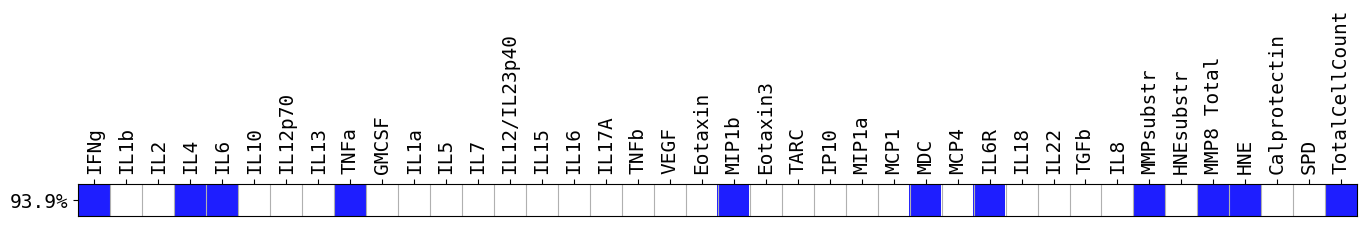

In [158]:
display_top_bms(f_indx, 1, [str(round(tm_acc, 2))+'%'])

In [39]:
# Read TM state
# tm_name="tm_posnonstrstap-%d-%d-%d-%d.pkl" % (20, 3, 2, 1856)
h = 11 
tm_name="./4ranges/tm-20-3-4.000000-639_1st-soluable.pkl" #1962 1895 1871 1870 1859 1838 736 804 945
if os.path.isfile(tm_name):
    with open(tm_name,'rb') as pickle_file:
        state = pickle.load(pickle_file)
    tm.set_state(state)
tm_max = tm
clause_score_av = clause_score_average(X_bn, Y, tm_max)
_, features_indx_1, features_indx_2 = top_dif_features(tm_max, 0, 1, clause_score_av=clause_score_av, clause ='all', normalized=True)
literals_indx = get_literals_indx(features_indx_2, tm_max)
print(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-(bms_no-h)*max_bits_per_feature*2]), X_bn) == Y).mean())

93.90243902439023


93.90243902439023
93.90243902439023
93.90243902439023
Display POSITIVE clauses with accuracy labels (True Positives / False Positives): class= 0
[20 39 33 35  0  4 28 36  8  3 26] HNE IFNg MIP1b IL22 IL6R TotalCellCount
[]


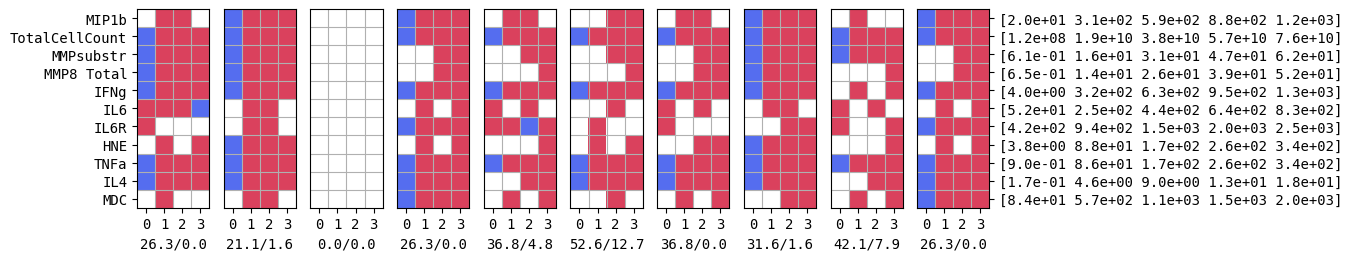

In [129]:
# Clauses structure
# Class-0: pos, neg, pos, neg ... Class-1: pos, neg, pos, neg
# Calculate clause score of for clauses with truncated features 
# defined in literals_indx[:-(49-k)*8]
k = 11 # the first k key biomarkers 
if bms_no == k:
    print('Use tm_clause_display() instead.')
else:
    clause_score_av = clause_score_average(X_bn, Y, tm_max)
    _, features_indx_1, features_indx_2 = top_dif_features(tm_max, 0, 1, clause_score_av=clause_score_av, clause ='all', normalized=True)
    literals_indx = get_literals_indx(features_indx_2, tm_max)
    print(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-(bms_no-k)*max_bits_per_feature*2]), X_bn) == Y).mean())
    trunc_clauses = get_tm_clauses_2(tm_max, literals_indx[:-(bms_no-k)*max_bits_per_feature*2])
    print(100*(tm_predict(tm_max, trunc_clauses, X_bn) == Y).mean())

    clause_score_av = clause_score_average_trunk(X_bn, Y, tm_max, trunc_clauses)

    # #--------------------------pruning 'poor' clauses----------------# #
    pruned_clauses = [] # Specify here clauses you would like to prun
    for j in pruned_clauses:
        trunc_clauses[j] = np.zeros(tm_max.number_of_features, dtype=np.uint8)
    print(100*(tm_predict(tm_max, trunc_clauses, X_bn) == Y).mean())
    clause_score_av = clause_score_average_trunk(X_bn, Y, tm_max, trunc_clauses)
    # #-------------------------end of pruning 'poor' clauses----------------
 
    yclass = 0
    polarity = 0
    clause_label = []
    if polarity == 0:
      print("Display POSITIVE clauses with accuracy labels (True Positives / False Positives): class=", yclass)
    else:
      print("Display NEGATIVE clauses with accuracy labels (True Negatives / False Negatives): class=", yclass)
    for i in range(tm_max.number_of_clauses//2):
      if polarity == 0:
        clause_label.append(str(round(clause_score_av[yclass, 0][polarity::2][i]*100, 1)) + '/' + str(round(clause_score_av[yclass, 1][polarity::2][i]*100, 1)))
      else:
        clause_label.append(str(round(clause_score_av[yclass, 1][polarity::2][i]*100, 1)) + '/' + str(round(clause_score_av[yclass, 0][polarity::2][i]*100, 1)))

    print(features_indx_2[:-(bms_no-k)], bm[36], bm[0], bm[20], bm[30], bm[28], bm[39])
    # Display clauses with truncated features defined in literals_indx[:-(49-k)*8]
    tm_clause_display_trunc(tm_max, x_shape = max_bits_per_feature, y_shape = k, features_indx = features_indx_2[:-(bms_no-k)], 
                            polarity = polarity, y = yclass, clause_lable = clause_label, 
                            bn_range = bn_range)
    print(np.sort(pruned_clauses))


# Plot a graph of TM accuracy depending on the number of included biomarkers
## Biomarkers are ordered according to their significance

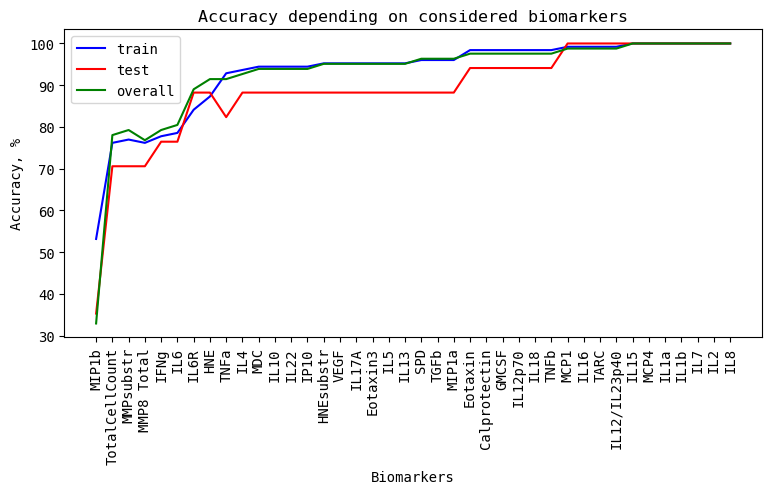

Biomarkers, ordered by their significance for classification:
['MIP1b', 'TotalCellCount', 'MMPsubstr', 'MMP8 Total', 'IFNg', 'IL6', 'IL6R', 'HNE', 'TNFa', 'IL4', 'MDC', 'IL10', 'IL22', 'IP10', 'HNEsubstr', 'VEGF', 'IL17A', 'Eotaxin3', 'IL5', 'IL13', 'SPD', 'TGFb', 'MIP1a', 'Eotaxin', 'Calprotectin', 'GMCSF', 'IL12p70', 'IL18', 'TNFb', 'MCP1', 'IL16', 'TARC', 'IL12/IL23p40', 'IL15', 'MCP4', 'IL1a', 'IL1b', 'IL7', 'IL2', 'IL8']

TM accuracy depending on the number of included biomarkers:
[32.926829268292686, 78.04878048780488, 79.26829268292683, 76.82926829268293, 79.26829268292683, 80.48780487804879, 89.02439024390245, 91.46341463414635, 91.46341463414635, 92.6829268292683, 93.90243902439023, 93.90243902439023, 93.90243902439023, 93.90243902439023, 95.1219512195122, 95.1219512195122, 95.1219512195122, 95.1219512195122, 95.1219512195122, 95.1219512195122, 96.34146341463415, 96.34146341463415, 96.34146341463415, 97.5609756097561, 97.5609756097561, 97.5609756097561, 97.5609756097561, 97.56

In [128]:
clause_score_av = clause_score_average(X_bn, Y, tm_max)
literals_indx, features_indx_1, features_indx_2 = top_dif_features(tm_max, 0, 1, clause_score_av=clause_score_av, clause ='all', normalized=True)
acc_train = []
acc_test = []
acc_all = []
literals_indx = get_literals_indx(features_indx_2, tm_max)

acc_train.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx), X_train) == Y_train).mean())
acc_test.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx), X_test) == Y_test).mean())
acc_all.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx), X_bn) == Y).mean())


for i in range(max_bits_per_feature*2, tm_max.number_of_features, max_bits_per_feature*2):
    acc_train.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-i]), X_train) == Y_train).mean())
    acc_test.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-i]), X_test) == Y_test).mean())
    acc_all.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-i]), X_bn) == Y).mean())

x = range(0, len(features_indx_2))
plt.figure(figsize=(9,4))
#plt.subplot(1, 2, 1)
plt.plot(x, acc_train[::-1], "b", label="train")
plt.plot(x, acc_test[::-1], "r", label="test")
plt.plot(x, acc_all[::-1], "g", label="overall")
plt.title("Accuracy depending on considered biomarkers")
plt.xlabel('Biomarkers')
plt.ylabel('Accuracy, %')
plt.legend(loc='best')
bm_ordered = [bm[index] for index in features_indx_2]
plt.xticks(np.arange(len(bm)), bm_ordered, rotation=90)
plt.show()

print('Biomarkers, ordered by their significance for classification:')
print(bm_ordered)
print('\nTM accuracy depending on the number of included biomarkers:')
print(acc_all[::-1])
print("\nOverall TM accuracy (>= 90%):  ", acc_all[np.argwhere(np.array(acc_all)>=90)[-1][0]], ', number of biomarkers: ', bms_no - np.argwhere(np.array(acc_all)>=90)[-1][0])
print("Overall TM accuracy (>= 95%):  ", acc_all[np.argwhere(np.array(acc_all)>=95)[-1][0]], ', number of biomarkers: ', bms_no - np.argwhere(np.array(acc_all)>=95)[-1][0])
print("Overall TM accuracy (>= 99%):  ", acc_all[np.argwhere(np.array(acc_all)>=99)[-1][0]], ', number of biomarkers: ', bms_no - np.argwhere(np.array(acc_all)>=99)[-1][0])
print("Overall TM accuracy (>= 100%): ", acc_all[np.argwhere(np.array(acc_all)>=100)[-1][0]], ', number of biomarkers: ', bms_no - np.argwhere(np.array(acc_all)>=100)[-1][0])

In [119]:
# Display a data sample horizontally
def x_display_h(x, x_size, y_size):    
    palette = np.array([[  218, 65, 93],    # red 
                        [  85, 109,  239]]) # blue; green: [  109, 239,  85]
    fig = plt.figure(figsize=(16.5, 3))
    ax = plt.subplot(1,1,1)
    ax.xaxis.tick_top()
    plt.xticks(np.arange(len(bm)), bm, rotation=90)
    plt.yticks(np.arange(0.5, y_size-0.5, 1), minor = True)
    plt.yticks(np.arange(0, y_size+1, 1), np.arange(y_size-1, -2, -1)) #(0, x_shape+1, 1)
    plt.xticks(np.arange(0.5, x_size-0.5, 1), minor = True)
    plt.tick_params(which='minor', top=False, bottom=False, left=False, right=False)
    plt.grid(which='minor')
    RGB = palette[x.reshape(x_size, y_size)]
    RGB = palette[np.flipud(x.reshape(x_size, y_size).transpose())]
    plt.imshow(RGB)

In [120]:
# Display a data sample vertically
def x_display_v(x, x_size, y_size):
    palette = np.array([[  218, 65, 93],      # red   
                        [  85, 109,  239]])   # blue; green: [  109, 239,  85]
    fig = plt.figure(figsize=(3, 16.5))
    ax = plt.subplot(1,1,1)
    plt.yticks(np.arange(len(bm)), bm)
    plt.yticks(np.arange(0.5, x_size-0.5, 1), minor = True)
    plt.xticks(np.arange(0, y_size+1, 1))
    plt.xticks(np.arange(0.5, y_size+0.5, 1), minor = True)
    plt.tick_params(which='minor', bottom=False, left=False, right=False)
    plt.grid(which='minor')
    RGB = palette[x.reshape(x_size, y_size)]
    plt.imshow(RGB)

# Displaying a data sample of Booleanized biomarkers 

Biomarker values:
[5.77494148e+00 2.21322841e-01 8.59821258e-01 4.64156183e-01
 8.33000000e+02 2.60173306e+00 9.97236728e-01 6.57004884e+00
 1.89193027e+01 8.81927485e-01 2.24684086e+01 1.00523150e+00
 2.19249790e+00 2.56769529e+01 2.59906929e+00 4.28254904e+01
 3.51051371e+00 3.24517767e-01 3.07053747e+00 5.32447966e+02
 4.04606544e+02 1.79995022e+01 1.90815751e+01 2.80000000e+03
 3.70861866e+01 2.52134192e+02 1.31364302e+02 1.29759952e+01
 1.64967166e+03 1.66182137e+01 2.57864577e+01 9.55718241e+01
 5.17834856e+01 3.37300000e+00 0.00000000e+00 9.71900000e+00
 1.82840000e+01 6.56980000e+01 1.78380300e+00 1.50000000e+09]

Visualisation of a data sample of Booleanized biomarkers:


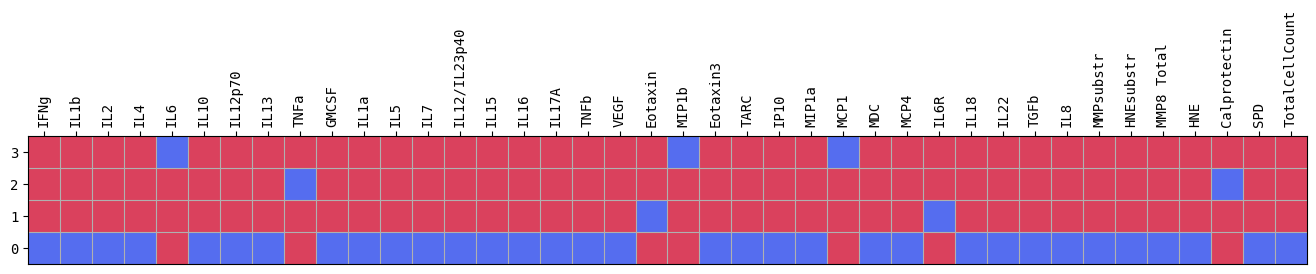

In [124]:
# Print biomarker values
print('Biomarker values:')
print(X[Y==0][0]) # e.g. sample 0 of class 0

# Display a data sample horizontally
print('\nVisualisation of a data sample of Booleanized biomarkers:')
x_display_h(X_bn[Y==1][0], x_size=bms_no, y_size=max_bits_per_feature)

# Display a data sample vertically
#x_display_v(X_bn[Y==1][0], x_size=bms_no, y_size=max_bits_per_feature)

# Displaying key Boolean features that are important for distinguishing between two classes
## The darker, the more important the feature is; Red color means that if the corresponding feature is True, then it is a witness for class 0, blue - for class 1.
## 1st template shows the main distinguishing features for positive clauses; 2nd - for negative clauses; 3rd - overall; 4th - shows the top n features

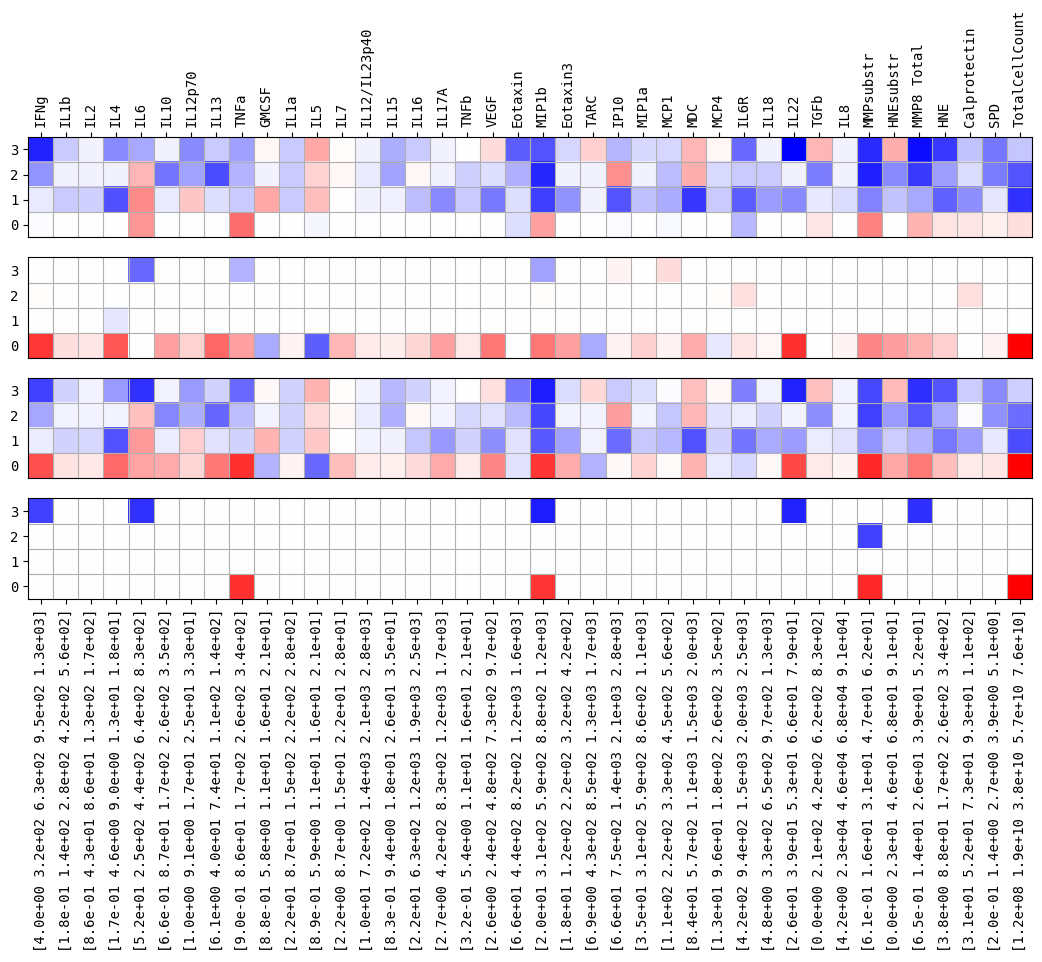

In [134]:
indx, weight, features_indx_1, features_indx_2 = top_dif_literals(tm_max, cl_0=1, cl_1=0, n=10, x_size=bms_no, y_size=max_bits_per_feature, 
                                clause_score_av=clause_score_av, clause ='all', normalized=True)

In [135]:
print(indx, weight)
x_test = X_bn[Y==0][0]
val = 0
for i in range(indx.shape[0]):
    val += x_test[indx[i]] * (weight[i]) 
print(val)    
x_test = X_bn[Y==1][0]
val = 0
for i in range(indx.shape[0]):
    val += x_test[indx[i]] * (weight[i]) 
print(val)  

[156  83 123 132 143  19  32  80 134   3] [ 2.2552783 -2.0031111 -1.939271   1.8864152 -1.8471403 -1.8277806
  1.826334   1.7842085 -1.6892333 -1.681382 ]
4.1402469873428345
0.3108018636703491


# Representation of TM clauses in the form of logical rules
## xi - is a certain semi-quantitative interval

In [993]:
print_clauses(tm_max)


Class #0 Positive Clauses:

Clause #0:  ¬x0
Clause #2:  
Clause #4:   x171
Clause #6:   x152
Clause #8:   x4 ∧  x19 ∧  x20 ∧  x24 ∧  x28 ∧  x36 ∧  x40 ∧  x44 ∧  x48 ∧  x52 ∧  x56 ∧  x60 ∧  x64 ∧  x68 ∧  x72 ∧  x84 ∧  x88 ∧  x116 ∧  x128 ∧ ¬x1 ∧ ¬x5 ∧ ¬x6 ∧ ¬x7 ∧ ¬x9 ∧ ¬x10 ∧ ¬x11 ∧ ¬x14 ∧ ¬x15 ∧ ¬x16 ∧ ¬x17 ∧ ¬x18 ∧ ¬x21 ∧ ¬x22 ∧ ¬x23 ∧ ¬x25 ∧ ¬x26 ∧ ¬x27 ∧ ¬x30 ∧ ¬x31 ∧ ¬x34 ∧ ¬x37 ∧ ¬x38 ∧ ¬x39 ∧ ¬x41 ∧ ¬x42 ∧ ¬x43 ∧ ¬x45 ∧ ¬x46 ∧ ¬x47 ∧ ¬x49 ∧ ¬x51 ∧ ¬x53 ∧ ¬x54 ∧ ¬x55 ∧ ¬x57 ∧ ¬x58 ∧ ¬x59 ∧ ¬x61 ∧ ¬x62 ∧ ¬x63 ∧ ¬x65 ∧ ¬x66 ∧ ¬x67 ∧ ¬x69 ∧ ¬x70 ∧ ¬x71 ∧ ¬x73 ∧ ¬x74 ∧ ¬x75 ∧ ¬x81 ∧ ¬x82 ∧ ¬x86 ∧ ¬x87 ∧ ¬x89 ∧ ¬x90 ∧ ¬x91 ∧ ¬x94 ∧ ¬x98 ∧ ¬x100 ∧ ¬x106 ∧ ¬x107 ∧ ¬x109 ∧ ¬x110 ∧ ¬x111 ∧ ¬x118 ∧ ¬x119 ∧ ¬x121 ∧ ¬x122 ∧ ¬x127 ∧ ¬x130 ∧ ¬x131 ∧ ¬x135 ∧ ¬x139 ∧ ¬x147 ∧ ¬x152 ∧ ¬x156 ∧ ¬x159 ∧ ¬x163 ∧ ¬x166 ∧ ¬x167 ∧ ¬x172 ∧ ¬x173 ∧ ¬x178 ∧ ¬x180 ∧ ¬x190 ∧ ¬x191 ∧ ¬x194 ∧ ¬x195
Clause #10:   x9 ∧ ¬x120
Clause #12:   x81 ∧  x171
Clause #14:   x4 ∧  x8 ∧  x24 ∧  x28 ∧  x36 ∧  x52 ∧  x60 ∧  x6

# Load and Booleanise the Biomarkers dataset
## Load the dataset for the certain classification step

In [54]:
X = np.loadtxt('bmarkers_x.csv', delimiter=',')
Y = np.loadtxt('bmarkers_5y.csv', delimiter=',').astype(int)
X = np.delete(X, 80, 0)
Y = np.delete(Y, 80, 0)
bm = ['IFNg', 'IL1b', 'IL2', 'IL4', 'IL6', 'IL10', 'IL12p70', 'IL13', 'TNFa', 'GMCSF', 'IL1a', 'IL5', 'IL7', 'IL12/IL23p40', 'IL15', 'IL16', 'IL17A', 'TNFb', 'VEGF', 'Eotaxin', 'MIP1b', 'Eotaxin3', 'TARC', 'IP10', 'MIP1a', 'MCP1', 'MDC', 'MCP4', 'IL6R', 'IL18', 'IL22', 'TGFb', 'IL8', 'MMPsubstr', 'HNEsubstr', 'Zym', 'MMP8 Total', 'HNE', 'Calprotectin', 'SPD', 'TotalCellCount', 'CD3+live(%)', 'CD14+live(%)', 'CD15+live(%)', 'CD4/CD8', 'CD4/CD3(%)', 'CD8/CD3(%)', 'g9T/CD3(%)', 'd2T/CD3(%)'] 

X = np.loadtxt('bmarkers_x.csv', delimiter=',')
Y = np.loadtxt('bmarkers_y_nogrowth.csv', delimiter=',').astype(int)
X = np.delete(X, 80, 0)
Y = np.delete(Y, 80, 0)

# X = np.loadtxt('bmarkers_x_posneg.csv', delimiter=',')
# Y = np.loadtxt('bmarkers_y_posneg.csv', delimiter=',').astype(int)
# X = np.delete(X, 61, 0)
# Y = np.delete(Y, 61, 0)

# X = np.loadtxt('bmarkers_x_posstrnstr.csv', delimiter=',')
# Y = np.loadtxt('bmarkers_y_posstrnstr.csv', delimiter=',').astype(int)
# X = np.delete(X, 46, 0)
# Y = np.delete(Y, 46, 0)

# X = np.loadtxt('bmarkers_x_posnonstrstap.csv', delimiter=',')
# Y = np.loadtxt('bmarkers_y_posnonstrstap.csv', delimiter=',').astype(int)

# Remove cellular biomarkers and Zym
X = np.delete(X[:,:-8], 35, 1)
bm = ['IFNg', 'IL1b', 'IL2', 'IL4', 'IL6', 'IL10', 'IL12p70', 'IL13', 'TNFa', 'GMCSF', 'IL1a', 'IL5', 'IL7', 'IL12/IL23p40', 'IL15', 'IL16', 'IL17A', 'TNFb', 'VEGF', 'Eotaxin', 'MIP1b', 'Eotaxin3', 'TARC', 'IP10', 'MIP1a', 'MCP1', 'MDC', 'MCP4', 'IL6R', 'IL18', 'IL22', 'TGFb', 'IL8', 'MMPsubstr', 'HNEsubstr', 'MMP8 Total', 'HNE', 'Calprotectin', 'SPD', 'TotalCellCount']

# # Remove soluble biomarkers
# X = np.concatenate((X[:,35:36], X[:,-8:]), axis=1)

bms_no = X.shape[1]
print('The dataset has been loaded: ', X.shape)

(82, 40)


## Dataset Booleanisation

In [55]:
max_bits_per_feature = 4
bn = Booleanizer(mdn = False, encoding = 'one_hot', max_bits_per_feature = max_bits_per_feature) #termometer
bn.fit(X)
X_bn = bn.transform(X)

In [56]:
bn_range = []
for i in range(len(bn.bins_list)):
  bn_range.append(np.array2string(np.array(bn.bins_list[i]), separator=' ', precision=2, formatter={'float_kind': '{:0.1e}'.format}))

## Split the dataset on training and testing subsets

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X_bn, Y, test_size=0.2, stratify=Y)  #, stratify = Y, random_state=36, 41, 49

## Balance the training dataset by oversampling

In [176]:
ros = RandomOverSampler()
X_train, Y_train = ros.fit_resample(X_train, Y_train)
print(X_bn.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(82, 160) (126, 160) (17, 160) (126,) (17,)


In [60]:
# # Write TM state
# file_name='tm_posnonstrstap-%d-%d-%d-%d.pkl' % (C, T, s, epoch)
# with open(file_name, 'wb') as handle:
#   pickle.dump(tm_max.get_state(), handle, protocol=pickle.HIGHEST_PROTOCOL)

# Create the Tsetlin Machine

In [61]:
C = 20
T = 3
s = 5
tm = MultiClassTsetlinMachine(C, T, s)         #(20, 3, 1.4)#(50, 5, 3)# (20, 3, 1.8) (20, 4, 3)
tm.fit(X_train, Y_train, epochs=0, incremental=True)
tm_train_results = []
tm_test_results = []

## It is possible to load a previously saved TM 

In [27]:
# # Read TM state
# # tm_name="tm_posnonstrstap-%d-%d-%d-%d.pkl" % (20, 3, 2, 1856)
# tm_name="./4ranges/tm-20-3-4.000000-639_1st-soluable.pkl"
# if os.path.isfile(tm_name):
#     with open(tm_name,'rb') as pickle_file:
#         state = pickle.load(pickle_file)
#         print('Loaded...')
#     tm.set_state(state)
# tm_max = tm

Loaded...


## Estimate accuracy of the loaded TM

In [178]:
y_train_predict = tm_max.predict(X_train)
y_test_predict = tm_max.predict(X_test)
y_all_predict = tm_max.predict(X_bn)
acc_train = np.array(100*(y_train_predict == Y_train).mean())
acc_test = np.array(100*(y_test_predict == Y_test).mean())
acc_all = np.array(100*(y_all_predict == Y).mean())
print(acc_train, acc_test, acc_all)

100.0 100.0 100.0


## Use this if you would like to save the current TM

In [179]:
# file_name='tm-%d-%d-%d-%d_nogrowth.pkl' % (C, T, s, epoch)
# with open(file_name, 'wb') as handle:
#     pickle.dump(tm_max.get_state(), handle, protocol=pickle.HIGHEST_PROTOCOL)

# Training of the Tsetlin Machine

In [272]:
acc_train_max = 0
acc_test_max = 0
acc_all_max = 0
epoch = 0

In [276]:
for i in tqdm(range(500)):
    tm.fit(X_train, Y_train, epochs=1, incremental=True)
    y_train_predict = tm.predict(X_train)
    y_test_predict = tm.predict(X_test)
    y_all_predict = tm.predict(X_bn)

    acc_train = np.array(100*(y_train_predict == Y_train).mean())
    acc_test = np.array(100*(y_test_predict == Y_test).mean())
    acc_all = np.array(100*(y_all_predict == Y).mean())
    tm_train_results = np.append(tm_train_results, acc_train)
    tm_test_results = np.append(tm_test_results, acc_test)
  # if acc_train >= acc_train_max:
  #   if acc_test >= acc_test_max:
  #     acc_test_max = acc_test
  #     acc_train_max = acc_train
  #     tm_max = copy.deepcopy(tm)
  #     epoch = i
    if (acc_test >= acc_test_max) and (acc_train >= acc_train_max):
#    if (acc_all >= acc_all_max):        
        acc_test_max = acc_test
        acc_train_max = acc_train
        acc_all_max = acc_all
        epoch = i
        tm_max = copy.deepcopy(tm)
#        if acc_test == 100 and acc_train == 100:
        if acc_all >= 100:
            epoch = i
            file_name='./tmp/tm-%d-%d-%f-%d_2nd-soluable.pkl' % (C, T, s, epoch)
            with open(file_name, 'wb') as handle:
                pickle.dump(tm_max.get_state(), handle, protocol=pickle.HIGHEST_PROTOCOL)
    if tm_train_results.max() == acc_train:
        y_train_predict_max = y_train_predict
    if tm_test_results.max() == acc_test:
        y_test_predict_max = y_test_predict

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 626.13it/s]


## Print the maximal train, test and overall accuracy achieved during TM training

In [277]:
#acc_all = np.array(100*(tm_max.predict(X_bn) == Y).mean())
print(tm_train_results.max(), tm_test_results.max(), epoch, acc_train_max, acc_test_max, acc_all_max)

100.0 100.0 490 100.0 100.0 100.0


## Plot TM train and test accuracy by epoch

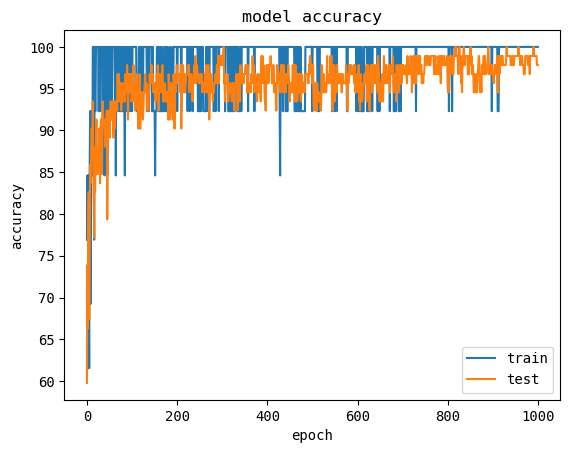

In [278]:
from matplotlib import pyplot as plt

plt.plot(tm_test_results[:])
plt.plot(tm_train_results[:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [279]:
indx90 = bms_no
tmp = indx90
folder = './tmp' #'./models' #'./4ranges'
target_acc = 90
k = 6
f_indx = np.zeros((1,k), dtype=np.uint8);
for file in os.listdir(folder):
    if fnmatch.fnmatch(file, '*_2nd-soluable.pkl'): #_nogrowth
#        print(file)
        with open(folder+'/'+file,'rb') as pickle_file:
            state = pickle.load(pickle_file)
        tm.set_state(state)
        if 100*(tm.predict(X_bn) == Y).mean() >= target_acc:
            tm_max = tm
            clause_score_av = clause_score_average(X_bn, Y, tm_max)
            tmp = bms_no
            literals_indx, features_indx_1, features_indx_2 = top_dif_features(tm_max, 0, 1, clause_score_av=clause_score_av, clause ='all', normalized=True)
            acc_train = []
            acc_test = []
            acc_all = []
            literals_indx = get_literals_indx(features_indx_2, tm_max)
    #        acc_train.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx), X_train) == Y_train).mean())
    #        acc_test.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx), X_test) == Y_test).mean())
            acc_all.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx), X_bn) == Y).mean())

            for i in range(max_bits_per_feature*2, tm_max.number_of_features, max_bits_per_feature*2):
    #            acc_train.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-i]), X_train) == Y_train).mean())
    #            acc_test.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-i]), X_test) == Y_test).mean())
                acc_all.append(100*(tm_predict(tm_max, get_tm_clauses_2(tm_max, literals_indx[:-i]), X_bn) == Y).mean())

            # if max(acc_all)>=target_acc:
            tmp = bms_no - np.argwhere(np.array(acc_all)>=target_acc)[-1][0]

            # else: 
            #     tmp = bms_no - np.argwhere(np.array(acc_all)==max(acc_all))[-1][0] 
            if indx90 >= tmp:
                indx90 = tmp
                print("------------------", file, indx90, acc_all[bms_no - indx90]) 
                if indx90 == k:
                    f_indx = np.append(f_indx, [sort(features_indx_2[0:k])], axis=0)
                    
            # else:
            #     os.remove(folder+'/'+file)
        else:
            print('Max accuracy is less than the target (', target_acc, '%)')

------------------ tm-20-3-4.000000-456_2nd-soluable.pkl 34 93.65079365079364
------------------ tm-20-3-4.000000-389_2nd-soluable.pkl 23 90.47619047619048
------------------ tm-20-3-4.000000-303_2nd-soluable.pkl 21 92.06349206349206


In [2211]:
# file_name='./2ranges/tm-%d-%d-%f-%d_1st-soluable.pkl' % (C, T, s, epoch)
# with open(file_name, 'wb') as handle:
#    pickle.dump(tm_max.get_state(), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [994]:
clause_score_av = clause_score_average(X_bn, Y, tm_max)
clause_score_av_train = clause_score_average(X_train, Y_train, tm_max)
clause_score_av_test = clause_score_average(X_test, Y_test, tm_max)

In [584]:
x_t = np.zeros((bms_no*max_bits_per_feature), dtype=np.uint32)
x_t[119] = 1
#print(x_t.reshape(49,4))
tm_max.transform(np.array([x_t]), inverted=False)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]], dtype=uint32)

In [585]:
xxx = np.zeros((2, bms_no*max_bits_per_feature), dtype=np.uint32)
xxx[0,119] = 1
yyy = np.zeros((2), dtype=np.uint32)
yyy[1] = 1
C = 20
T = 3
s = 2
tm = MultiClassTsetlinMachine(C, T, s)         #(20, 3, 1.4)#(50, 5, 3)# (20, 3, 1.8) (20, 4, 3)
tm.fit(xxx, yyy, epochs=0, incremental=True)
#Read TM state
tm_name="tm_posnonstrstap-%d-%d-%d-%d.pkl" % (20, 3, 2, 1856)
if os.path.isfile(tm_name):
    with open(tm_name,'rb') as pickle_file:
        state = pickle.load(pickle_file)
    tm.set_state(state)
tm.transform(xxx[0:1], inverted=False)

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]],
      dtype=uint32)

In [586]:
mask_0_neg, mask_0_pos = clause_mask(tm_max, 0, 0)
mask_1_neg, mask_1_pos = clause_mask(tm_max, 0, 1)
print(mask_1_pos.reshape(bms_no, max_bits_per_feature))

[[8. 0. 0.]
 [8. 0. 0.]
 [9. 0. 0.]
 [4. 0. 0.]
 [0. 0. 9.]
 [6. 0. 0.]
 [6. 0. 0.]
 [9. 0. 0.]
 [1. 0. 1.]
 [8. 0. 0.]
 [8. 0. 0.]
 [8. 0. 0.]
 [9. 0. 0.]
 [8. 0. 0.]
 [9. 0. 0.]
 [5. 2. 0.]
 [8. 0. 0.]
 [9. 0. 0.]
 [5. 0. 0.]
 [0. 0. 3.]
 [0. 0. 5.]
 [6. 0. 0.]
 [9. 0. 0.]
 [0. 0. 3.]
 [4. 0. 1.]
 [0. 0. 9.]
 [6. 1. 0.]
 [9. 0. 0.]
 [0. 4. 2.]
 [8. 0. 0.]
 [6. 0. 0.]
 [3. 0. 0.]
 [9. 0. 0.]
 [1. 2. 0.]
 [3. 0. 0.]
 [1. 1. 2.]
 [1. 1. 0.]
 [0. 1. 1.]
 [1. 1. 0.]
 [5. 0. 0.]]


In [ ]:
#top_dif_literals(tm_max, cl_0=0, cl_1=1, n = 10, x_size = 49, y_size = 4, clause_score_av = clause_score_av, clause = 'positive')
top_dif_literals(tm_max, cl_0=0, cl_1=1, n = 10, x_size = bms_no, y_size = max_bits_per_feature, clause = 'positive')

In [239]:
for yclass in range(2):
  for polarity in range(2):
    clause_label = []
    if polarity == 0:
      print("Display POSITIVE clauses with accuracy labels (True Positives / False Positives): class=", yclass)
    else:
      print("Display NEGATIVE clauses with accuracy labels (True Negatives / False Negatives): class=", yclass)
    for i in range(tm_max.number_of_clauses//2):
      if polarity == 0:
        clause_label.append(str(round(clause_score_av[yclass, 0][polarity::2][i]*100, 2)) + '/' + str(round(clause_score_av[yclass, 1][polarity::2][i]*100, 2)))
      else:
        clause_label.append(str(round(clause_score_av[yclass, 1][polarity::2][i]*100, 2)) + '/' + str(round(clause_score_av[yclass, 0][polarity::2][i]*100, 2)))
    print('yclass/polarity: ', yclass, '/', polarity)
    print(clause_label)

Display POSITIVE clauses with accuracy labels (True Positives / False Positives): class= 0
yclass/polarity:  0 / 0
['26.32/0.0', '15.79/0.0', '5.26/0.0', '15.79/0.0', '31.58/0.0', '31.58/0.0', '31.58/0.0', '15.79/0.0', '26.32/0.0', '15.79/0.0']
Display NEGATIVE clauses with accuracy labels (True Negatives / False Negatives): class= 0
yclass/polarity:  0 / 1
['25.4/0.0', '28.57/0.0', '80.95/73.68', '65.08/15.79', '0.0/0.0', '0.0/0.0', '6.35/0.0', '0.0/0.0', '25.4/0.0', '25.4/0.0']
Display POSITIVE clauses with accuracy labels (True Positives / False Positives): class= 1
yclass/polarity:  1 / 0
['20.63/0.0', '33.33/0.0', '33.33/0.0', '7.94/0.0', '28.57/0.0', '36.51/0.0', '0.0/0.0', '4.76/0.0', '1.59/0.0', '0.0/0.0']
Display NEGATIVE clauses with accuracy labels (True Negatives / False Negatives): class= 1
yclass/polarity:  1 / 1
['15.79/0.0', '36.84/0.0', '36.84/0.0', '15.79/0.0', '0.0/0.0', '21.05/0.0', '36.84/0.0', '26.32/0.0', '15.79/0.0', '21.05/0.0']


In [151]:
print("Max Train Accuracy: ", tm_train_results.max())
print("Max Test Accuracy:  ", tm_test_results.max())

# print(classification_report(Y_train, y_train_predict_max))
print(classification_report(Y_test, y_test_predict_max))
# tn, fp, fn, tp = confusion_matrix(Y_train, y_train_predict, labels=[0, 1]).ravel()
# print("      TP/FP; TN/FN: ", tp, "/", fp, "; ", tn, "/", fn)

Max Train Accuracy:  100.0
Max Test Accuracy:   47.05882352941176
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.40      0.67      0.50         3
           2       0.40      0.50      0.44         4
           4       1.00      0.50      0.67         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.47        17
   macro avg       0.30      0.30      0.28        17
weighted avg       0.42      0.47      0.43        17



/home/aria/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aria/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aria/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


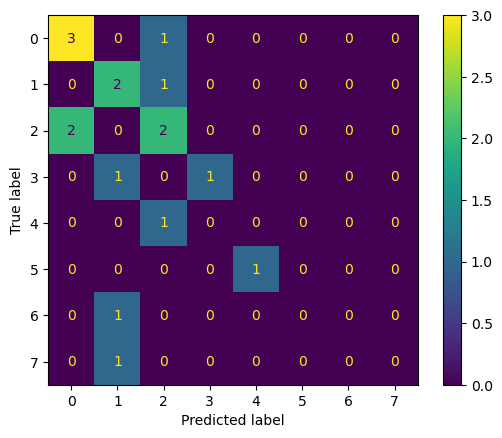

In [152]:
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, y_test_predict_max))

cm_display.plot()
plt.show()

In [1000]:
print(tm_max.transform(X_bn[Y==1][0:1], inverted=False))
clause_outputs = tm_max.transform(X_bn[Y==1][0:1], inverted=False)
print('Class-0, positive clause outputs: ', clause_outputs[0][0:20:2])
print('Class-0, negative clause outputs: ', clause_outputs[0][1:20:2])
print('Class-1, positive clause outputs: ', clause_outputs[0][20:40:2])
print('Class-1, negative clause outputs: ', clause_outputs[0][21:40:2])
print(Y[Y==1][0])

[[0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
  0 0 0 0]]
Class-0, positive clause outputs:  [0 0 0 0 0 0 0 0 0 0]
Class-0, negative clause outputs:  [1 1 0 1 0 0 0 0 0 0]
Class-1, positive clause outputs:  [1 0 0 1 0 0 0 1 0 0]
Class-1, negative clause outputs:  [0 0 0 0 0 0 0 0 0 0]
1


Display NEGATIVE clauses with accuracy labels (True Negatives / False Negatives): class= 0


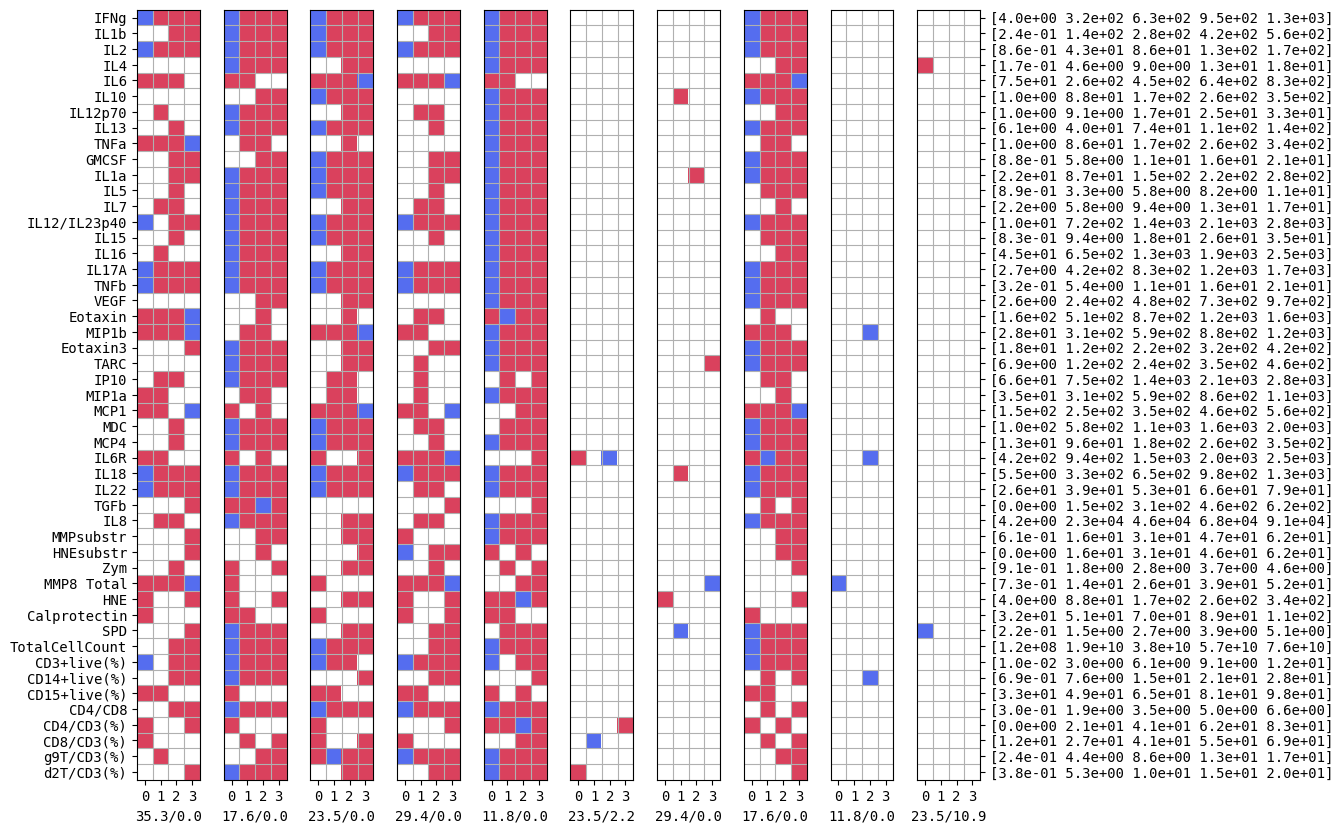

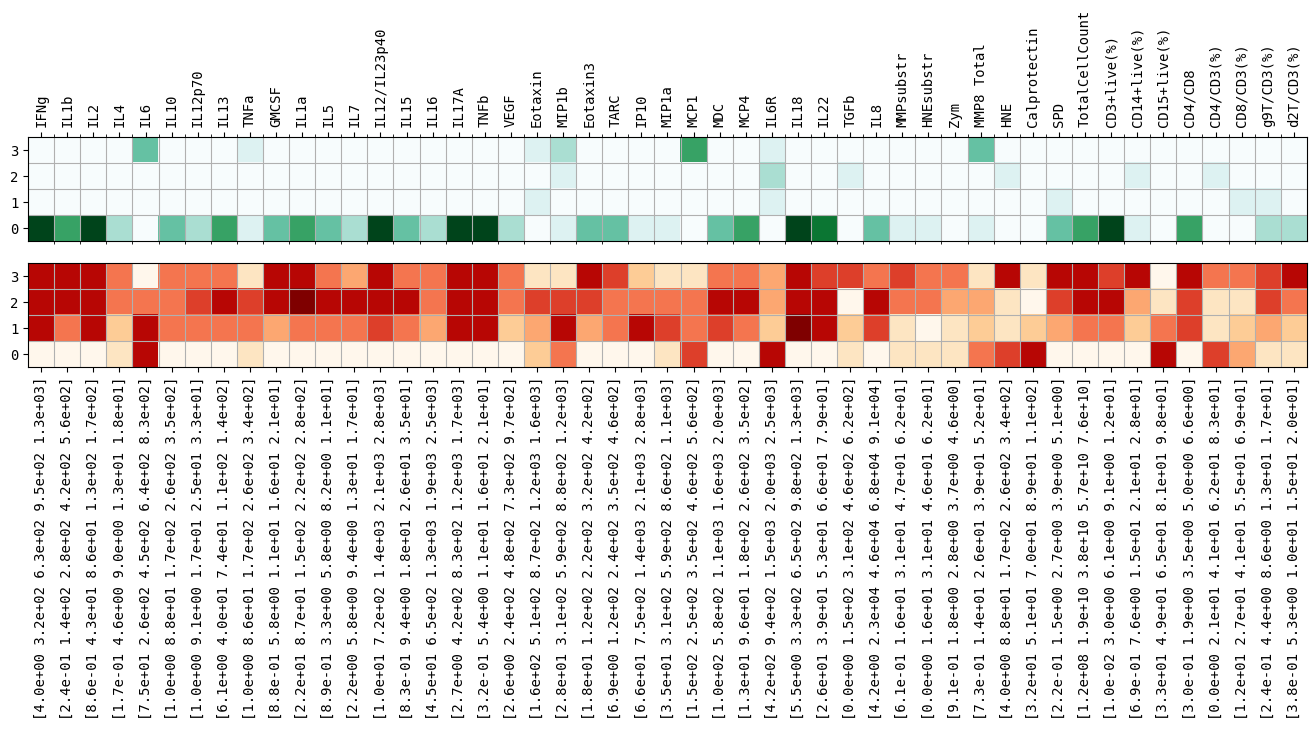

In [995]:
yclass = 0
polarity = 1
clause_label = []
if polarity == 0:
  print("Display POSITIVE clauses with accuracy labels (True Positives / False Positives): class=", yclass)
else:
  print("Display NEGATIVE clauses with accuracy labels (True Negatives / False Negatives): class=", yclass)
for i in range(tm_max.number_of_clauses//2):
  if polarity == 0:
    clause_label.append(str(round(clause_score_av[yclass, 0][polarity::2][i]*100, 1)) + '/' + str(round(clause_score_av[yclass, 1][polarity::2][i]*100, 1)))
  else:
    clause_label.append(str(round(clause_score_av[yclass, 1][polarity::2][i]*100, 1)) + '/' + str(round(clause_score_av[yclass, 0][polarity::2][i]*100, 1)))
tm_clause_display(tm_max, x_shape = max_bits_per_feature, y_shape = bms_no, polarity = polarity, y = yclass, clause_lable = clause_label, bn_range = bn_range)

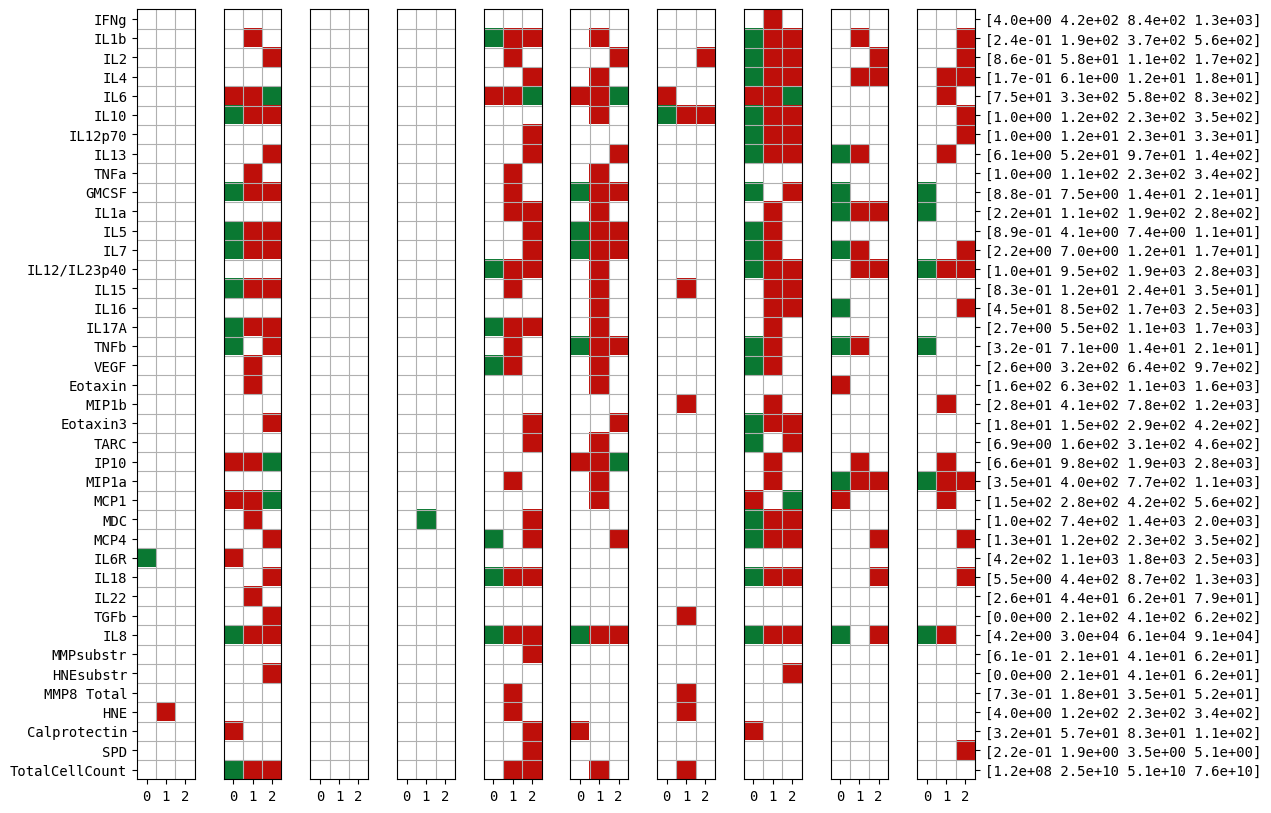

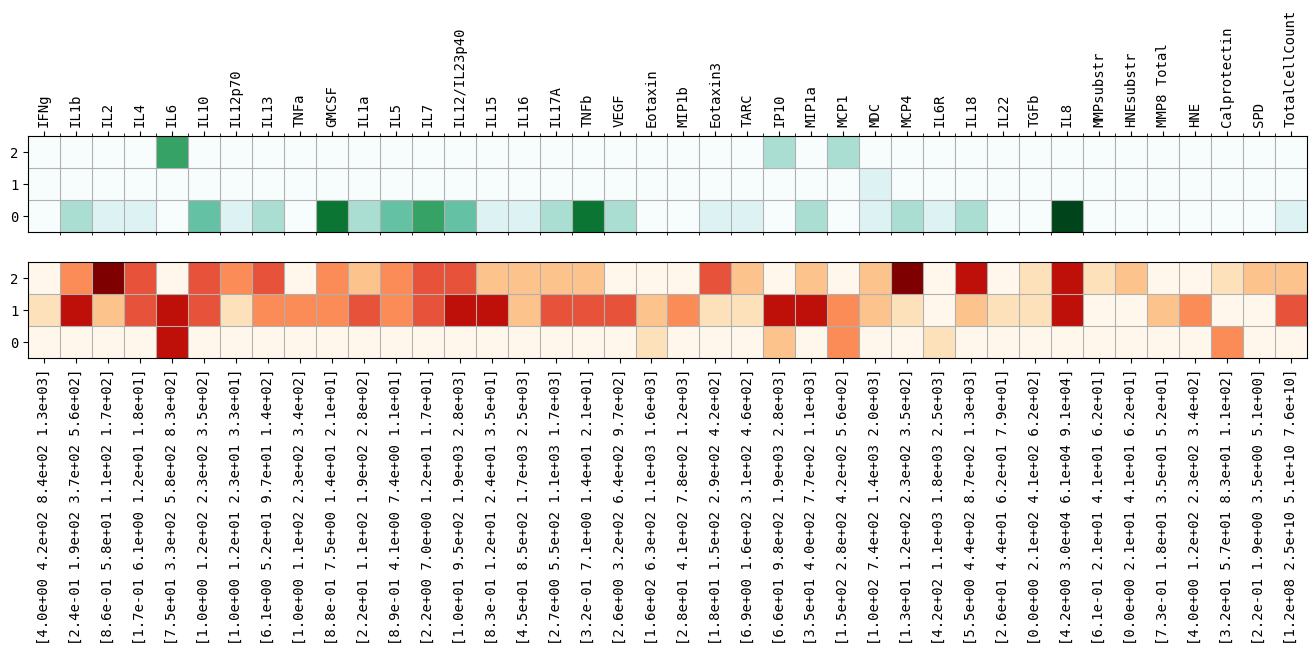

In [452]:
tm_clause_display(tm_max, x_shape = max_bits_per_feature, y_shape = bms_no, polarity = 0, y = 0, bn_range = bn_range)

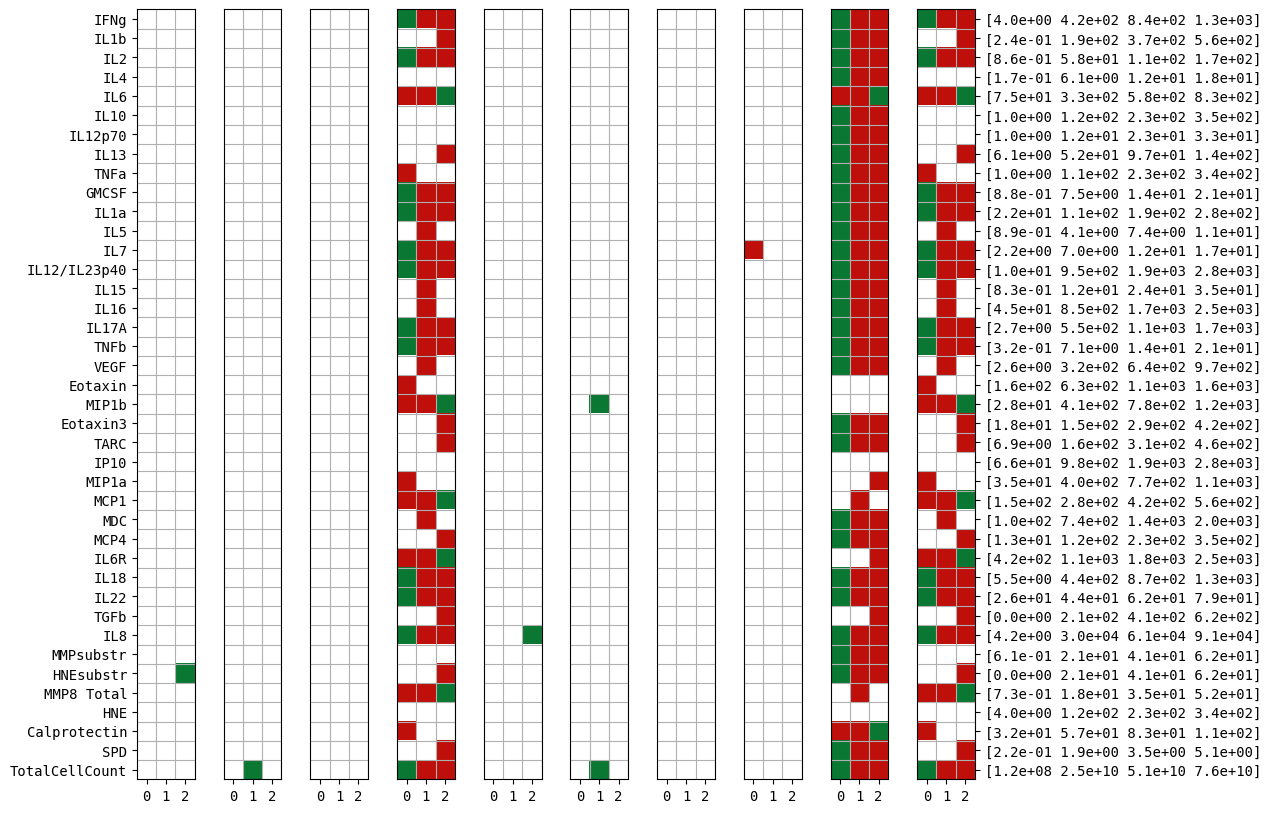

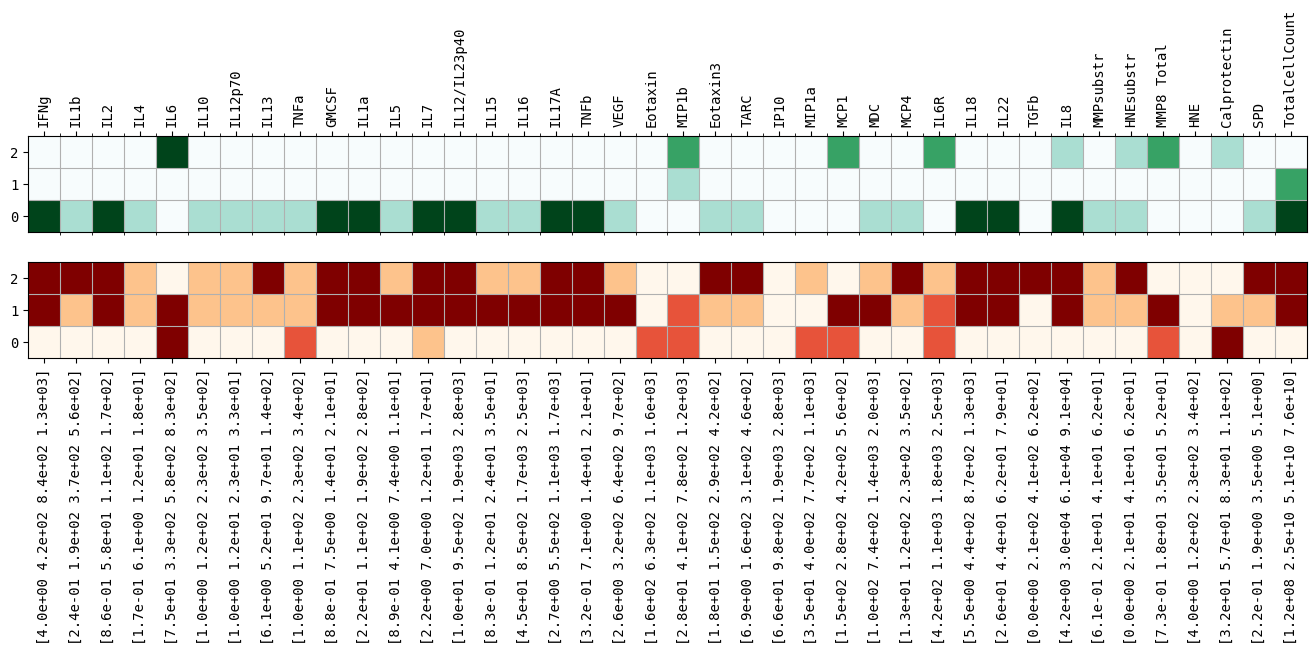

In [453]:
tm_clause_display(tm_max, x_shape = max_bits_per_feature, y_shape = bms_no, polarity = 1, y = 0, bn_range = bn_range)

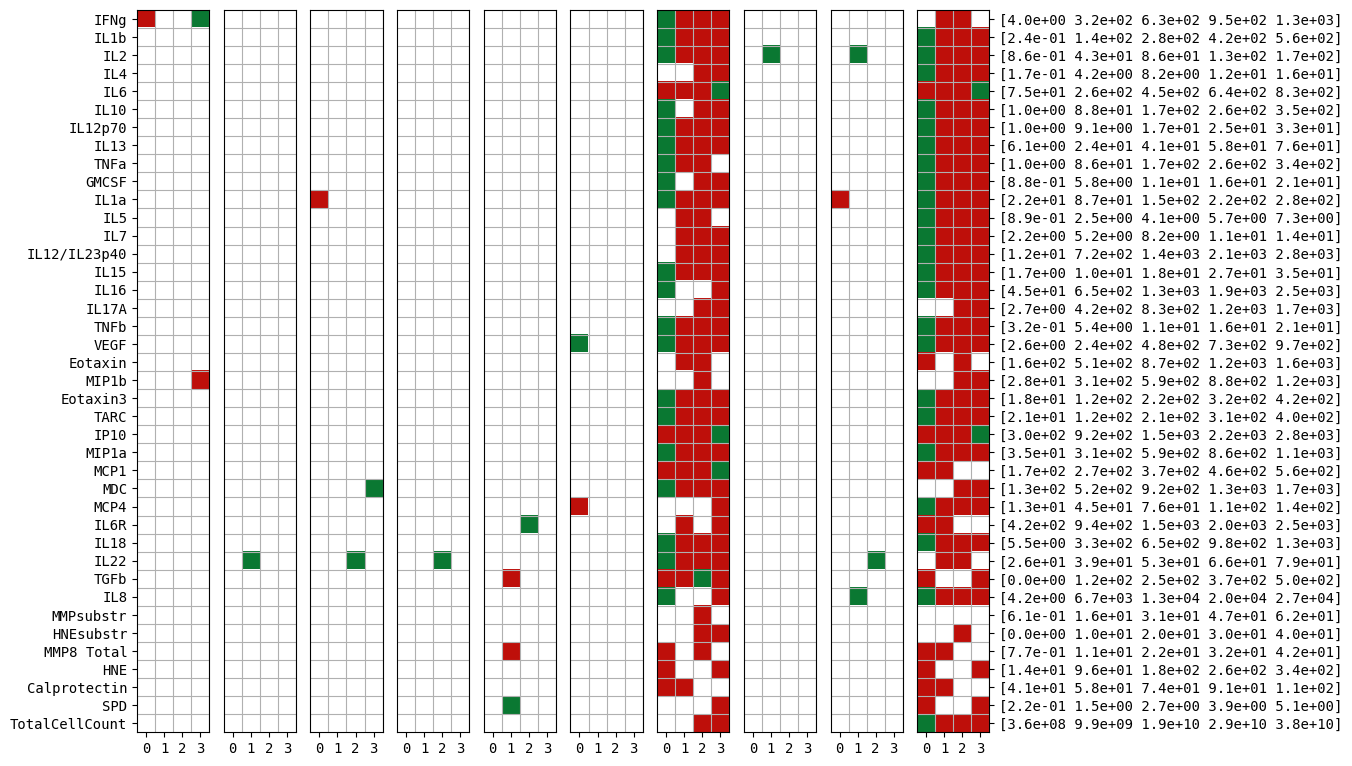

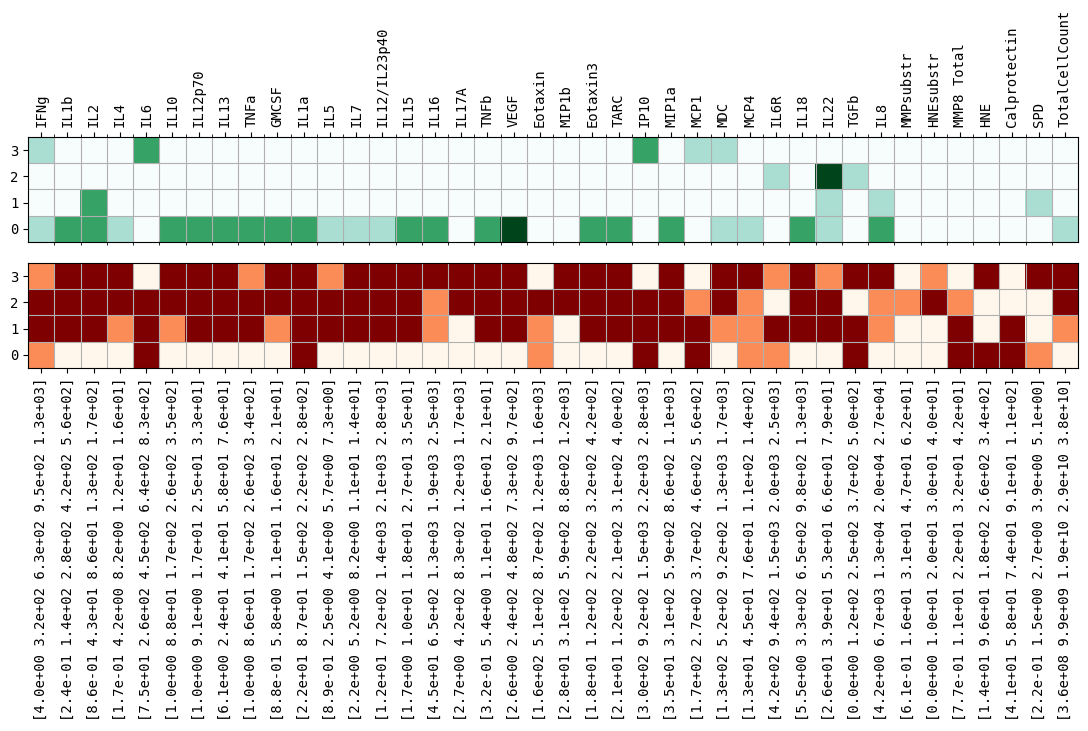

In [1060]:
tm_clause_display(tm_max, x_shape = max_bits_per_feature, y_shape = bms_no, polarity = 0, y = 1, bn_range = bn_range)

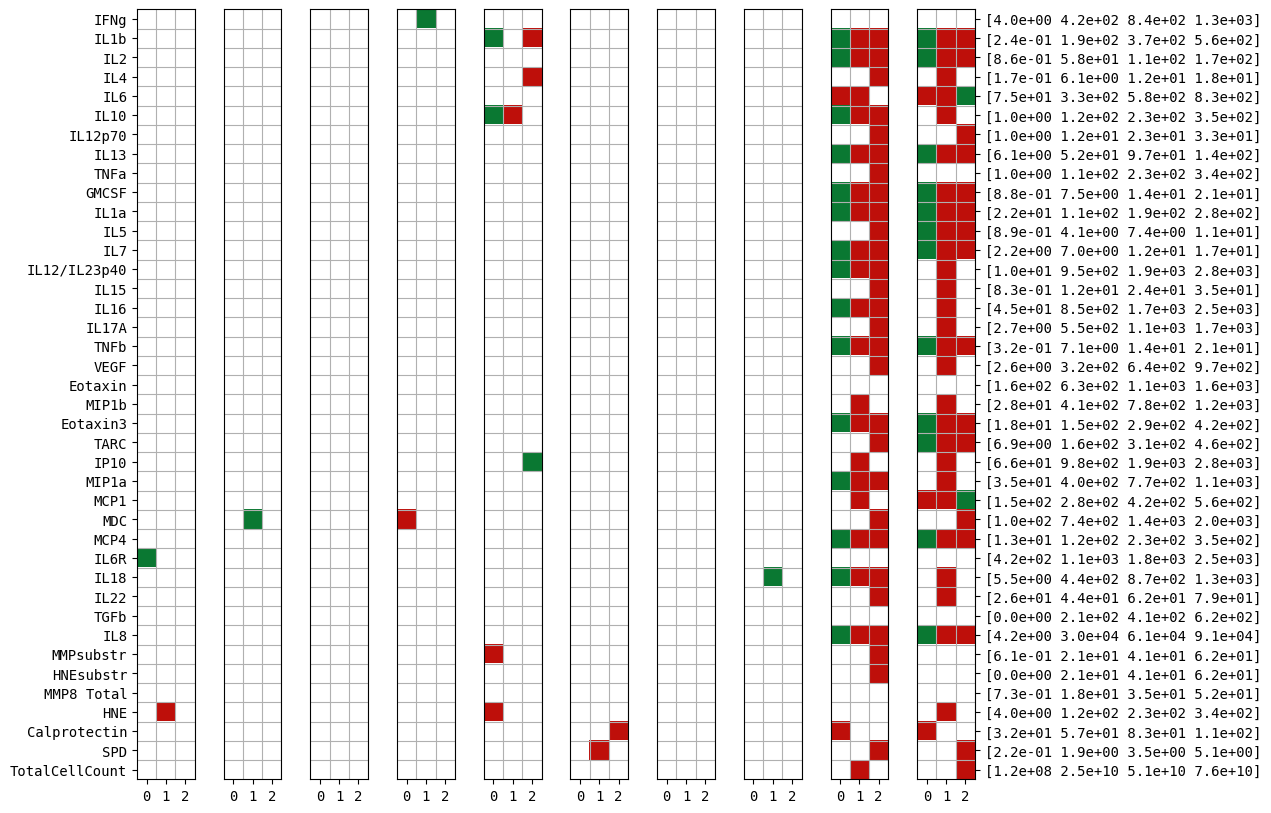

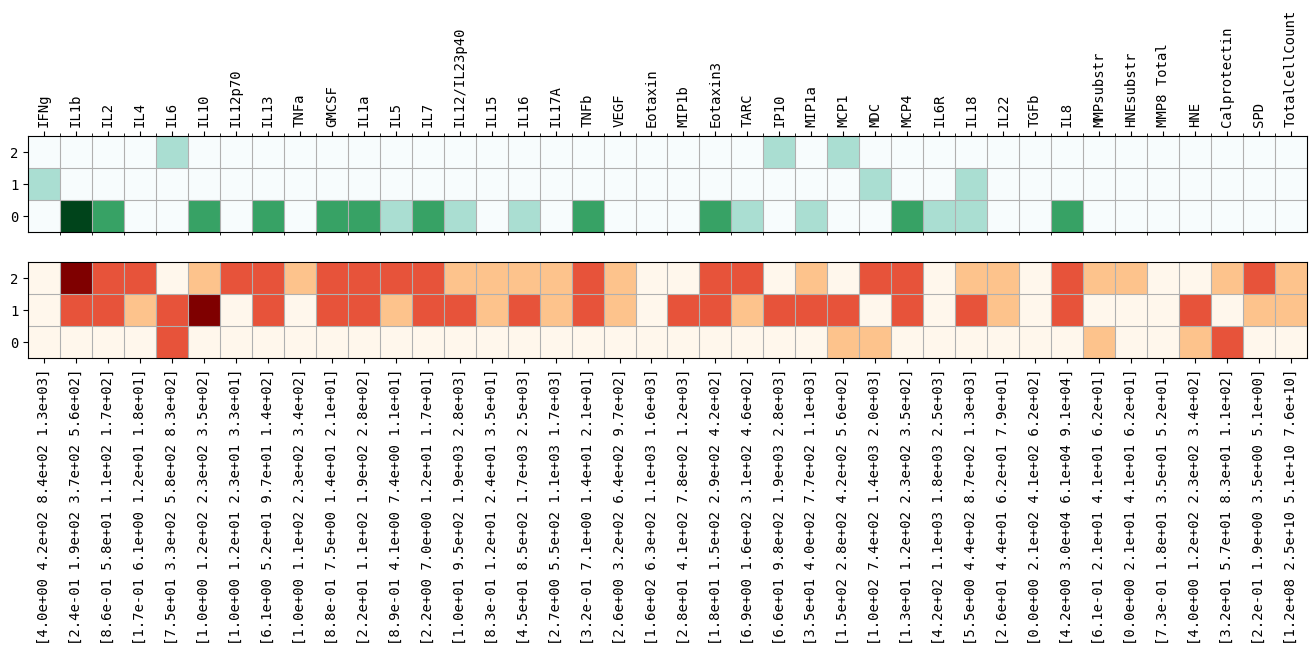

In [455]:
tm_clause_display(tm_max, x_shape = 3, y_shape = 49-9, polarity = 1, y = 1, bn_range = bn_range)

/tmp/ipykernel_109/1212368478.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if clause_score_av == []:


[0.3548387  0.32258064 0.2580645  0.29032257 0.29032257 0.29032257
 0.38709676 0.32258064 0.19354838 0.22580644]
[0.1875     0.3125     0.375      0.3125     0.3125     0.25
 0.46774194 0.125      0.3125     0.1875    ]
[ 0.3125      0.25        0.25        0.0625     -0.03225806  0.
  0.43548387  0.25        0.25        0.1875    ]
[0.09677419 0.         0.03225806 0.38709676 0.03225806 0.
 0.03225806 0.38709676 0.03225806 0.29032257]
[ 35 105 134  78   5 172  99  57  89  85  22  61  29 147  33  97 119  83
 168   0 141  69 143 139 158 163  46  43 129  75 118  23 115 178 182 192
  39 156 123 190  36  52 130  38  56 128  95  96 186  72  44  68 103  64
  48  60 108 116 188  88 175  84  40  24   4 136 176   8  12 164  19  28
 160  20  66 120  45 133  58  10 138  21 157  93 112 170 185 125 132  54
  13  51  55  26  94 121  30  11 148 144  32 162  42 165 153  87 142 154
 150 137  77 124 146 111 107  53 171 122 181 126 109 184 113 106 114 187
  92 149 104  50  98 177 189   2  59 173  37  41 

(array([192, 105, 193,  35,  32,  78, 134, 127,  20, 103]),
 array([ 2.060606 ,  1.928231 , -1.8513732,  1.725898 , -1.6364983,
         1.5866636,  1.550873 , -1.4343466, -1.3623682,  1.2792377],
       dtype=float32),
 array([16, 10,  9, 32, 39,  7, 18, 15,  3, 43, 40, 27, 31, 48, 34, 21, 38,
        28, 23,  4, 14, 29, 17, 46, 22,  8,  2, 44, 42, 20, 45,  6, 26,  5,
        49, 24, 41, 37, 36, 33, 25, 30, 11, 13, 12, 19, 47, 35,  1],
       dtype=uint32),
 array([48, 25,  8, 26, 20, 19,  0,  1, 15, 22,  6, 45, 43, 24,  4, 21,  7,
        33, 42, 12, 18,  5, 31, 44, 29,  3, 41, 17, 38, 16, 37, 14, 11, 36,
        10, 35,  2, 40, 32, 27, 28, 47, 30, 39,  9, 46, 23, 34, 13]))

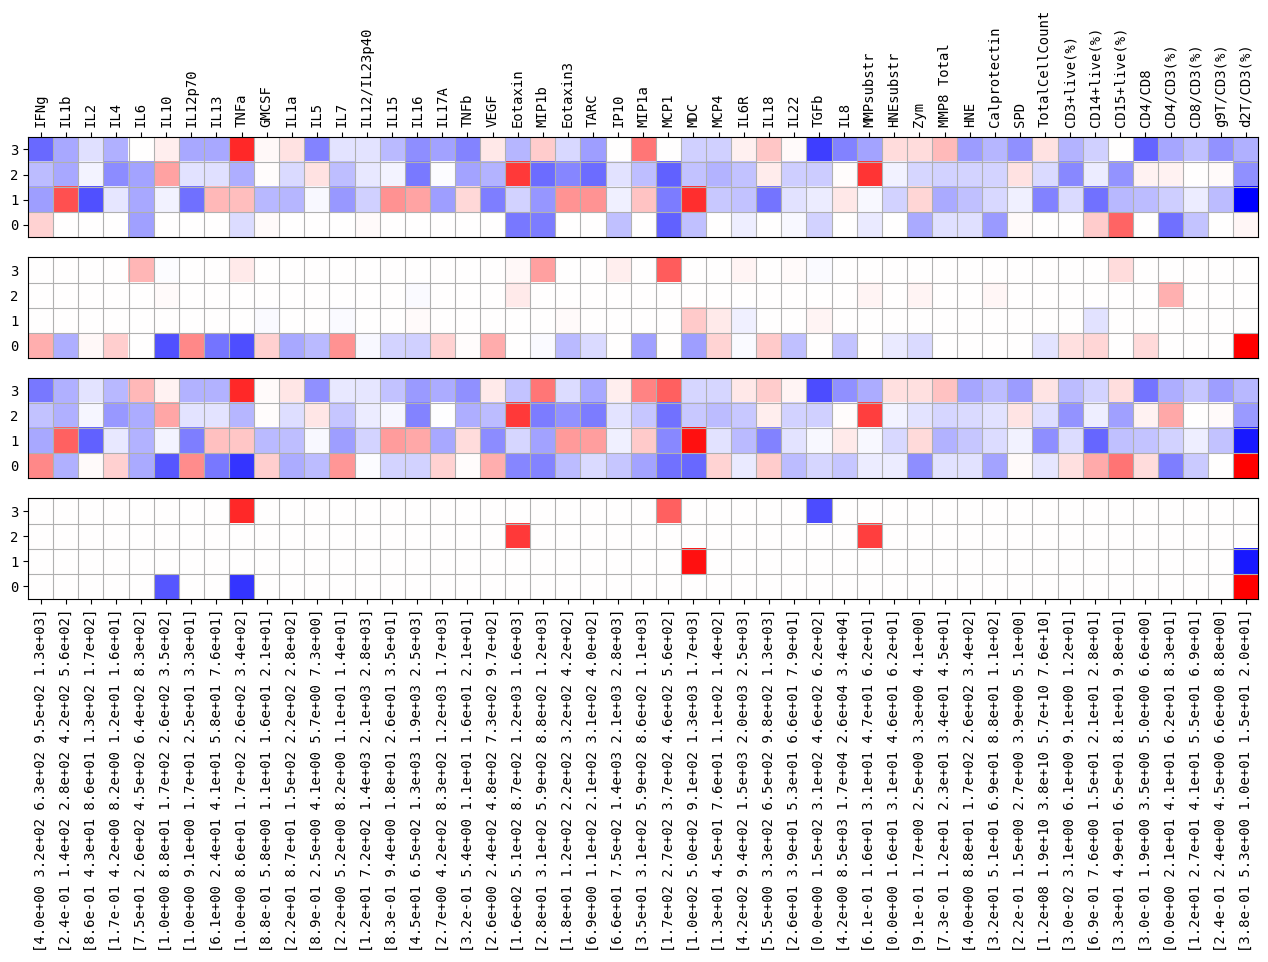

In [187]:
top_dif_literals(tm_max, cl_0=0, cl_1=1, n=10, x_size=bms_no, y_size=max_bits_per_feature, clause_score_av=clause_score_av, clause ='All', normalized=True)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 31 151 134  85 123  73  22 135  55  26  27  21 158 147  93 139 166 111
  59  97  34   1   9 187  43 122 121 159  63  70  35  81  41  74  65  98
 191  13 109 179 117  90 163 161   7   6 195 173  10 105 180 129  86 190
  87 162  11 126  45   5  29  66  42 171 143  51  61 165 130  23  71  30
 184  38 189 142   3 115  78 137 138  39 118  82  49 152  33  83 150 181
 119 133  37  99 193  75  69 194  15 131  18 141  54 167  58 112 175  50
  76  62 102 148 107  67 155  92 101 157 146  16 172 183 168 103  14 185
 113  56 149 145  19 186 125 178  89  95  79  53 127  47 124 164 154  36
 128  84 182 136  40  28  96  88  24  20 140   8 176  72  44 156 108  48
  64   4  80  12  77 188 116 104  60 174 110 153 106  91  46 192   0  52
  68 144  25  94 177 100 160 132 114  17 170   2 169  57 120  32]


(array([ 97,  32, 120, 123, 192,  73,   1, 135,  21,  31]),
 array([ 2.804762 , -2.75     , -2.6666667,  2.2142859, -2.05     ,
         2.047619 ,  1.9714286,  1.9476191,  1.9047619,  1.9      ],
       dtype=float32),
 array([ 6, 27, 22, 33, 48,  8, 14,  9,  2, 45, 19, 42, 43, 15, 25, 31, 11,
        21,  5, 46, 30, 13, 35, 17,  1, 49, 37, 23, 44, 29,  3, 41, 39,  7,
        20, 28, 16, 12, 47, 18, 10, 24, 40, 36, 34, 38, 26, 32,  4],
       dtype=uint32),
 array([30, 40,  8,  5, 21, 33, 18, 24, 48, 10,  7, 16,  2,  1, 29,  6, 17,
        47, 39,  3,  0, 14, 13, 41, 34, 20, 35, 42, 15, 43,  9, 27, 37, 36,
        46, 32, 28, 23, 45, 12, 44, 26, 22,  4, 25, 11, 19, 31, 38]))

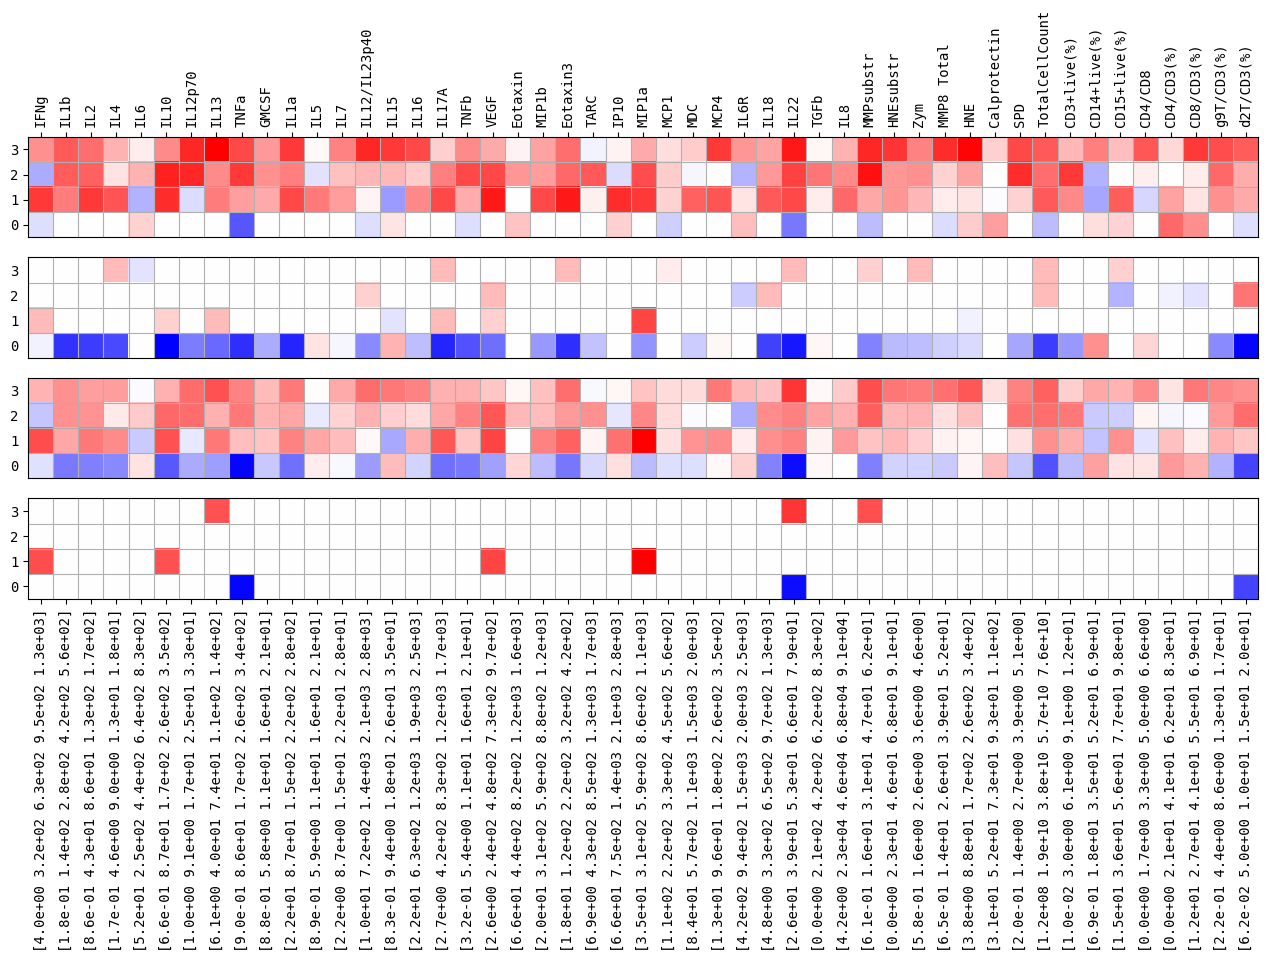

In [410]:
top_dif_literals(tm_max, cl_0=0, cl_1=1, n=10, x_size=bms_no, y_size=max_bits_per_feature, clause_score_av=[], clause='all', normalized=True)

In [ ]:
print(np.array2string(np.array(bn.bins_list)[40], separator=' ', floatmode='fixed', precision=2))
print(np.array2string(np.array(bn.bins_list)[0], separator=' ', floatmode='fixed', precision=2))
print(np.array2string(np.array(bn.bins_list)[0], separator=' ', floatmode='maxprec_equal', precision=2))
print(np.array2string(np.array(bn.bins_list)[0], separator=' ', precision=2, formatter={'complexfloat': lambda x: x}))
print(np.array2string(np.array(bn.bins_list)[0], separator=' ', precision=2, formatter={'float_kind': '{:0.2e}'.format}))
print(np.array2string(np.array(bn.bins_list)[0], separator=' ', precision=2, floatmode='fixed', formatter={'complexfloat':lambda x: ":12.2f" }))

[1.20e+08 1.91e+10 3.81e+10 5.70e+10 7.60e+10]
[   4.01  318.01  632.00  946.00 1260.00]
[   4.01  318.01  632.00  946.00 1260.00]
[   4.01  318.01  632.    946.   1260.  ]
[4.0e+00 3.2e+02 6.3e+02 9.5e+02 1.3e+03]
[   4.01  318.01  632.00  946.00 1260.00]


# Two layer TM

In [ ]:
tm1 = tm

In [ ]:
#evaluate TM-1 training and validation accuracy
acc_train_1 = 100*(tm1.predict(X_train) == Y_train).mean()
acc_val_1 = 100*(tm1.predict(X_test) == Y_test).mean()
print('TM-1 training accuracy (100 training epochs):   ', acc_train_1)
print('TM-1 validation accuracy (100 training epochs): ', acc_val_1)

TM-1 training accuracy (100 training epochs):    100.0
TM-1 validation accuracy (100 training epochs):  100.0


In [ ]:
#create TM-2
tm2 = MultiClassTsetlinMachine(20, 3, 5)
#tune TM-2 using as an input TM-1 clause outputs
#tm.transform method returns raw TM clause outputs corresponding to the input dataset
tm2.fit(tm1.transform(X_train), Y_train, epochs=2000)

#evaluate TM-2 training and validation accuracy; notice how is the input defined
acc_train_2 = 100*(tm2.predict(tm1.transform(X_train)) == Y_train).mean()
acc_val_2 = 100*(tm2.predict(tm1.transform(X_test)) == Y_test).mean()
print('TM-2 training accuracy (100 tuning epochs):   ', acc_train_2)
print('TM-2 validation accuracy (100 tuning epochs): ', acc_val_2)

TM-2 training accuracy (100 tuning epochs):    98.48484848484848
TM-2 validation accuracy (100 tuning epochs):  47.05882352941176


# 3-fold stratified cross-validation

In [ ]:
# 3-fold stratified cross-validation
tm_val_results = np.empty(0)
tm_train_results = np.empty(0)

skf = StratifiedKFold(n_splits=5)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify = Y)
# print(X_tr.shape)

i = 0
for   train, val in skf.split(X_train, Y_train):
  print(Y_train[train].shape, Y_train[val].shape, 'train -  {}   |   val -  {}'.format(np.bincount(Y_train[train]), np.bincount(Y_train[val])))
  tm.fit(X_train[train], Y_train[train], epochs=1000, incremental=False)
  y_train_predict = tm.predict(X_train[train])
  y_val_predict = tm.predict(X_train[val])
  tm_train_results = np.append(tm_train_results, np.array(100*(y_train_predict == Y_train[train]).mean()))
  tm_val_results = np.append(tm_val_results, np.array(100*(y_val_predict == Y_train[val]).mean()))
  print("#%d Train Accuracy (max/mean): %.2f%% / %.2f%% +/- %.2f" % (i+1, tm_train_results.max(), tm_train_results.mean(), 1.96*tm_train_results.std()/np.sqrt(i+1)))
  print("#%d Val Accuracy (max/mean): %.2f%% / %.2f%% +/- %.2f" % (i+1, tm_val_results.max(), tm_val_results.mean(), 1.96*tm_val_results.std()/np.sqrt(i+1)))
  i = i + 1
  result = np.round(confusion_matrix(Y_train[val], y_val_predict), 2) #normalize='pred'
  df_cm = pd.DataFrame(result, index=range(0, result.shape[0]), columns=range(0, result.shape[1]))
  cmap = 'Oranges'

tm.fit(X_train, Y_train, epochs=1000, incremental=False)
y_train_predict = tm.predict(X_train)
y_test_predict = tm.predict(X_test)
print("Train Accuracy: ", 100*(y_train_predict == Y_train).mean())
print("Val Accuracy: ", 100*(y_test_predict == Y_test).mean())

#  pp_matrix(df_cm, cmap = cmap)




(120,) (31,) train -  [12 12 15 13 15 13 13 15 12]   |   val -  [3 4 4 4 3 3 4 3 3]
#1 Train Accuracy (max/mean): 99.17% / 99.17% +/- 0.00
#1 Val Accuracy (max/mean): 77.42% / 77.42% +/- 0.00
(121,) (30,) train -  [12 13 16 14 14 13 13 14 12]   |   val -  [3 3 3 3 4 3 4 4 3]
#2 Train Accuracy (max/mean): 99.17% / 99.17% +/- 0.00
#2 Val Accuracy (max/mean): 83.33% / 80.38% +/- 4.10
(121,) (30,) train -  [12 13 15 14 14 13 14 14 12]   |   val -  [3 3 4 3 4 3 3 4 3]
#3 Train Accuracy (max/mean): 99.17% / 98.34% +/- 1.32
#3 Val Accuracy (max/mean): 83.33% / 76.92% +/- 6.17
(121,) (30,) train -  [12 13 15 14 14 13 14 14 12]   |   val -  [3 3 4 3 4 3 3 4 3]
#4 Train Accuracy (max/mean): 100.00% / 98.76% +/- 1.21
#4 Val Accuracy (max/mean): 83.33% / 76.85% +/- 4.63
(121,) (30,) train -  [12 13 15 13 15 12 14 15 12]   |   val -  [3 3 4 4 3 4 3 3 3]
#5 Train Accuracy (max/mean): 100.00% / 98.18% +/- 1.40
#5 Val Accuracy (max/mean): 83.33% / 76.82% +/- 3.71
Train Accuracy:  99.33774834437085
Val

In [ ]:
tm_test_results = np.empty(0)
tm_train_results = np.empty(0)

# for i in range(100):
# 	tm.fit(X_train, Y_train, epochs=1)
# 	tm_results = np.append(tm_results, np.array(100*(tm.predict(X_test) == Y_test).mean()))
# 	print("#%d Average Accuracy: %.2f%% +/- %.2f" % (i+1, tm_results.mean(), 1.96*tm_results.std()/np.sqrt(i+1)))

for i in range(1):
  for j in range(1000):
    tm.fit(X_train, Y_train, epochs=1, incremental=True)
    tm_train_results = np.append(tm_train_results, np.array(100*(tm.predict(X_train) == Y_train).mean()))
    tm_test_results = np.append(tm_test_results, np.array(100*(tm.predict(X_test) == Y_test).mean()))
  print("#%d Train Accuracy (max/mean): %.2f%% / %.2f%% +/- %.2f" % (i+1, tm_train_results.max(), tm_train_results.mean(), 1.96*tm_train_results.std()/np.sqrt(i+1)))
  print("#%d Test Accuracy (max/mean): %.2f%% / %.2f%% +/- %.2f" % (i+1, tm_test_results.max(), tm_test_results.mean(), 1.96*tm_test_results.std()/np.sqrt(i+1)))

#1 Train Accuracy (max/mean): 100.00% / 98.74% +/- 12.55
#1 Test Accuracy (max/mean): 29.41% / 12.27% +/- 4.00


In [ ]:
tm = MultiClassTsetlinMachine(20, 3, 1.5)

In [ ]:
print("\nMean accuracy over 100 runs:\n")
tm_results = np.empty(0)

# for i in range(100):
# 	tm.fit(X_train, Y_train, epochs=1)
# 	tm_results = np.append(tm_results, np.array(100*(tm.predict(X_test) == Y_test).mean()))
# 	print("#%d Average Accuracy: %.2f%% +/- %.2f" % (i+1, tm_results.mean(), 1.96*tm_results.std()/np.sqrt(i+1)))

for i in range(10):
  tm.fit(X_train, Y_train, epochs=100, incremental=True)
  tm_results = np.append(tm_results, np.array(100*(tm.predict(X_test) == Y_test).mean()))
  print("#%d Average Accuracy: %.2f%% +/- %.2f" % (i+1, tm_results.mean(), 1.96*tm_results.std()/np.sqrt(i+1)))


Mean accuracy over 100 runs:

#1 Average Accuracy: 89.47% +/- 0.00
#2 Average Accuracy: 90.35% +/- 1.22
#3 Average Accuracy: 90.64% +/- 0.94
#4 Average Accuracy: 90.79% +/- 0.74
#5 Average Accuracy: 90.88% +/- 0.62
#6 Average Accuracy: 90.94% +/- 0.52
#7 Average Accuracy: 91.35% +/- 0.88
#8 Average Accuracy: 91.34% +/- 0.77
#9 Average Accuracy: 91.62% +/- 0.86
#10 Average Accuracy: 91.58% +/- 0.78


In [ ]:
np.linspace(X[:,0].min(), X[:,0].max(), 3)[1:-1]

array([17.5455])

In [ ]:
print(b.number_of_features)
b.bins_list

30


[array([17.5455]),
 array([24.495]),
 array([116.145]),
 array([1322.25]),
 array([0.108015]),
 array([0.18239]),
 array([0.2134]),
 array([0.1006]),
 array([0.205]),
 array([0.0737]),
 array([1.49225]),
 array([2.6226]),
 array([11.3685]),
 array([274.501]),
 array([0.0164215]),
 array([0.068826]),
 array([0.198]),
 array([0.026395]),
 array([0.043416]),
 array([0.0153674]),
 array([21.985]),
 array([30.78]),
 array([150.805]),
 array([2219.6]),
 array([0.146885]),
 array([0.542645]),
 array([0.626]),
 array([0.1455]),
 array([0.41015]),
 array([0.13127])]

In [1142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
# Load and normalize the dataset

# X_ann = np.loadtxt('bmarkers_x.csv', delimiter=',')
# Y_ann = np.loadtxt('bmarkers_y_nogrowth.csv', delimiter=',').astype(int)
# X_ann = np.delete(X_ann, 80, 0)
# Y_ann = np.delete(Y_ann, 80, 0)

# X_ann = np.loadtxt('bmarkers_x_posneg.csv', delimiter=',')
# Y_ann = np.loadtxt('bmarkers_y_posneg.csv', delimiter=',').astype(int)
# X_ann = np.delete(X_ann, 61, 0)
# Y_ann = np.delete(Y_ann, 61, 0)

# X_ann = np.loadtxt('bmarkers_x_posstrnstr.csv', delimiter=',')
# Y_ann = np.loadtxt('bmarkers_y_posstrnstr.csv', delimiter=',').astype(int)
# X_ann = np.delete(X_ann, 46, 0)
# Y_ann = np.delete(Y_ann, 46, 0)

# X_ann = np.loadtxt('bmarkers_x_posnonstrstap.csv', delimiter=',')
# Y_ann = np.loadtxt('bmarkers_y_posnonstrstap.csv', delimiter=',').astype(int)

# compute the mean of each column
col_means = np.mean(X_ann, axis=0)
# normalize each column by subtracting its mean and dividing by its standard deviation
X_ann = (X_ann - col_means) / np.std(X_ann, axis=0)

#X_ann = (X_ann - np.min(X_ann))/(np.max(X_ann) - np.min(X_ann))
#print(X_ann[0])
# bmarkers_y.csv bmarkers_y_nogrowth.csv bmarkers_y_nogrnegpos.csv bmarkers_y_nogrnegstrnonstr.csv
# bmarkers_y_neg.csv bmarkers_y_pos.csv bmarkers_y_posstr.csv bmarkers_y_posnstr.csv

# # Remove a patient with the mixed bacteria infection
# X_ann = np.delete(X, 80, 0)
# Y_ann = np.delete(Y, 80, 0)

# Remove cellular biomarkers and Zym
X_ann = np.delete(X_ann[:,:-8], 35, 1)
print(Y_ann.shape, X_ann.shape)

(82,) (82, 40)


In [1149]:
x_train, x_test, y_train, y_test = train_test_split(X_ann, Y_ann, test_size=0.2, stratify = Y_ann)

ros = RandomOverSampler()
x_train, y_train = ros.fit_resample(x_train, y_train)

# # for multiclass classification
# y_train = utils.to_categorical(y_train, 5)
# y_test = utils.to_categorical(y_test, 5) 

print(x_train.shape, y_train.shape, max(y_train), x_test.shape, y_test.shape, max(y_test))

(85, 40) (85,) 4 (17, 40) (17,) 4


In [1139]:
# ANN creation: Binary classification, 1 hidden layer, 8000 neurons
model = Sequential()
model.add(Dense(12800, input_dim=x_train.shape[1], activation="relu")) 
model.add(Dense(1, activation='sigmoid')) # for binary classification
#model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
model.compile(loss='binary_crossentropy', optimizer="SGD", metrics=["accuracy"])

In [1140]:
# ANN training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=1, epochs=50, verbose=0)
# ANN testing
train_acc = model.evaluate(x_train, y_train)
test_acc = model.evaluate(x_test, y_test)
print(train_acc, test_acc)

1/1 [==============================] - 0s 63ms/step - loss: 0.8482 - accuracy: 0.5714
[0.021648146212100983, 1.0] [0.8481759428977966, 0.5714285969734192]


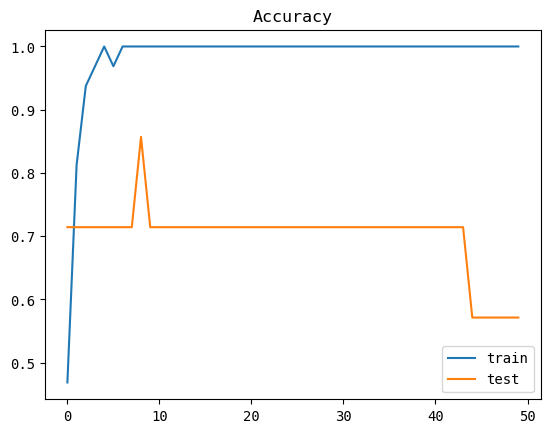

Max. val. accuracy:  0.8571428656578064 0.7142857313156128


In [1141]:
from matplotlib import pyplot
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()
print('Max. val. accuracy: ', max(history.history['val_accuracy']), history.history['val_accuracy'][11])

In [1162]:
# ALL Dataset
X_ann = np.loadtxt('bmarkers_x.csv', delimiter=',')
Y_ann = np.loadtxt('bmarkers_5y.csv', delimiter=',').astype(int)
# Remove a patient with the mixed bacteria infection
X_ann = np.delete(X_ann, 80, 0)
Y_ann = np.delete(Y_ann, 80, 0)


# Remove cellular biomarkers and Zym
X_ann = np.delete(X_ann[:,:-8], 35, 1)

# compute the mean of each column
col_means = np.mean(X_ann, axis=0)
# normalize each column by subtracting its mean and dividing by its standard deviation
X_ann = (X_ann - col_means) / np.std(X_ann, axis=0)

print(Y_ann.shape, X_ann.shape)

x_train, x_test, y_train, y_test = train_test_split(X_ann, Y_ann, test_size=0.2, stratify = Y_ann)

ros = RandomOverSampler()
x_train, y_train = ros.fit_resample(x_train, y_train)

# for multiclass classification
y_train = utils.to_categorical(y_train, 5)
y_test = utils.to_categorical(y_test, 5) 

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(82,) (82, 40)
(85, 40) (85, 5) (17, 40) (17, 5)


In [1163]:
# ANN: Multiclass classification, 1 hidden layer, 20000 neurons

model = Sequential()
model.add(Dense(32000, input_dim=x_train.shape[1], activation="relu")) 
model.add(Dense(5, activation="softmax")) # for multiclass classification
model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

# ANN training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=1, epochs=50, verbose=0)
# ANN testing
train_acc = model.evaluate(x_train, y_train)
test_acc = model.evaluate(x_test, y_test)
print(train_acc, test_acc)

1/1 [==============================] - 0s 18ms/step - loss: 2.5830 - accuracy: 0.3529
[0.030604101717472076, 1.0] [2.583009719848633, 0.3529411852359772]


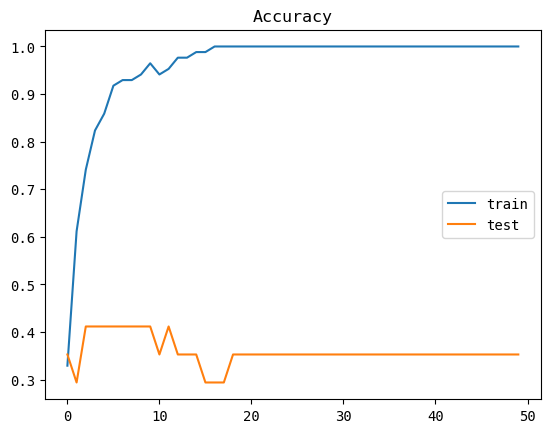

Max. val. accuracy:  0.4117647111415863 0.3529411852359772


In [1164]:
from matplotlib import pyplot
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()
print('Max. val. accuracy: ', max(history.history['val_accuracy']), history.history['val_accuracy'][30])

In [ ]:
print(classification_report(y_test, utils.to_categorical(np.argmax(model.predict(x_test), axis=-1),9)))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.25      0.50      0.33         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0

   micro avg       0.29      0.29      0.29        17
   macro avg       0.15      0.18      0.16        17
weighted avg       0.26      0.29      0.27        17
 samples avg       0.29      0.29      0.29        17



/home/aria/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aria/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
